In [19]:
import os
import time
import re

import math

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import rpy2
from rpy2.robjects import numpy2ri
from rpy2.robjects import pandas2ri
numpy2ri.activate()
pandas2ri.activate()

from pygam import LogisticGAM, s

from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.metrics import precision_recall_curve, confusion_matrix, auc
from sklearn.metrics import roc_curve, f1_score

from scipy.stats import wasserstein_distance as wd

import pims
from tqdm.auto import tqdm

from lib import detection
from lib import analysis
from lib import display

# Visualization stuff
cargo_pal = sns.color_palette(['goldenrod', 'blue', 'purple'])
cell_pal = sns.blend_palette(sns.color_palette(),18)

# Classifier V3.0: A New Hope??

We have a whole new set of cells. Let's train a classifier on them!

## Sample Selection

I've scored 22 movies total. We've used 4 of those movies for building the fPCA object that we project the puffs into for generating the features, so we're going to exclude those 4 movies from the classifier.

Ideally, I will have sampled randomly and have an equal number of cells from each condition. In reality, here's what condition_checker tells me:

```
condition_checker.py ~/UM\ Drive/OPP/OPP_scramble.log 1606ZQOT.tif 3WE2GUYC.tif 42GSRFR0.tif 53BFW81Q.tif 56CCWWJI.tif 5FWR8G3N.tif 5RTVNBXU.tif 6SG3YVW7.tif 79NWKD4H.tif 7C4SV01F.tif 7XFW332I.tif 7XGJBQQ3.tif 7YFIHF8P.tif 8C92MS0M.tif 9VEA7WGA.tif ACSKAOE5.tif AVRI5TNO.tif BLPOHKJD.tif
5 B2 cells, 6 MOR cells, 7 TfR Cells
```

So that's not...GREAT. But it's a start for a classifier. So, how do we do this?

Load up movies and import scored features for the included movies:

In [28]:
logfile = '/Volumes/Coatamer/Users/weinberz/UM Drive/OPP/OPP_scramble.log'
basedir = '/Volumes/Coatamer/Users/weinberz/UM Drive/OPP'
files = os.listdir(basedir)
tifs = [tif for tif in files if 'tif' in tif]
xmls = [xml for xml in files if 'xml' in xml]
movie_info = {}
for tif in tifs:
    movie_name = tif.split('.')[0]
    matches = [xml for xml in xmls if movie_name in xml]
    if matches:
        movie_info[movie_name] = {'tif' : tif,
                                  'xml' : matches[0]}

excluded_movies = [movie_info.pop(movie, None) for movie in ['0IYVHRNA','19CC75ZU','2TZWB6CN','3W70AV4V']]

In [29]:
(' ').join([movie_info[movie]['tif'] for movie in movie_info])

'1606ZQOT.tif 3WE2GUYC.tif 42GSRFR0.tif 53BFW81Q.tif 56CCWWJI.tif 5FWR8G3N.tif 5RTVNBXU.tif 6SG3YVW7.tif 79NWKD4H.tif 7C4SV01F.tif 7XFW332I.tif 7XGJBQQ3.tif 7YFIHF8P.tif 8C92MS0M.tif 9VEA7WGA.tif ACSKAOE5.tif AVRI5TNO.tif BLPOHKJD.tif'

In [35]:
def get_cargo_id(cell, logfile):
    content = open(logfile,'r').read()

    p = re.compile("(tfr|b2|mor).*"+cell+".*?\n")
    res = p.search(content)
    if res is not None:
        if res.group(1) == 'b2':
            return('B2')
        elif res.group(1) == 'mor':
            return('MOR')
        elif res.group(1) == 'tfr':
            return('TfR')
    
    raise NameError('Cell name not found in logfile.')

features_list = []
for movie in movie_info:
    features = pd.read_csv('data' + os.sep + movie + ".tif_features.csv", index_col=0)
    features['cell'] = movie
    for feature_to_norm in ['intden', 'deltaf']:
        features[feature_to_norm + '_norm'] = features[feature_to_norm] / np.mean(features[feature_to_norm])
    features_list.append(features)
    print('%d puffs in %d events (%.4f puff rate)' % (np.sum(features['puff']),
                                                      len(features),
                                                      (np.sum(features['puff'])/len(features))))

labeled_sample = pd.concat(features_list, ignore_index=True)
cells = np.unique(labeled_sample['cell'])
for cell in cells:
    labeled_sample.loc[labeled_sample['cell'] == cell, 'cargo'] = get_cargo_id(cell, logfile)

147 puffs in 6079 events (0.0242 puff rate)
488 puffs in 9346 events (0.0522 puff rate)
62 puffs in 8909 events (0.0070 puff rate)
509 puffs in 10203 events (0.0499 puff rate)
71 puffs in 6002 events (0.0118 puff rate)
108 puffs in 10202 events (0.0106 puff rate)
37 puffs in 9594 events (0.0039 puff rate)
482 puffs in 7765 events (0.0621 puff rate)
34 puffs in 3511 events (0.0097 puff rate)
254 puffs in 10725 events (0.0237 puff rate)
266 puffs in 6732 events (0.0395 puff rate)
72 puffs in 7732 events (0.0093 puff rate)
16 puffs in 4843 events (0.0033 puff rate)
604 puffs in 8056 events (0.0750 puff rate)
183 puffs in 3715 events (0.0493 puff rate)
78 puffs in 7258 events (0.0107 puff rate)
35 puffs in 7628 events (0.0046 puff rate)
118 puffs in 5827 events (0.0203 puff rate)


Text(0.5, 1.0, 'Perimeter of Convex Hull')

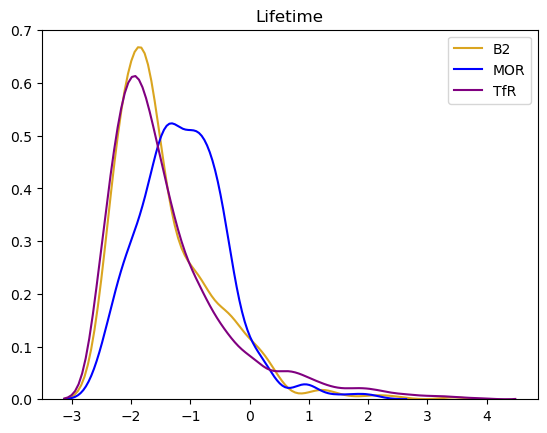

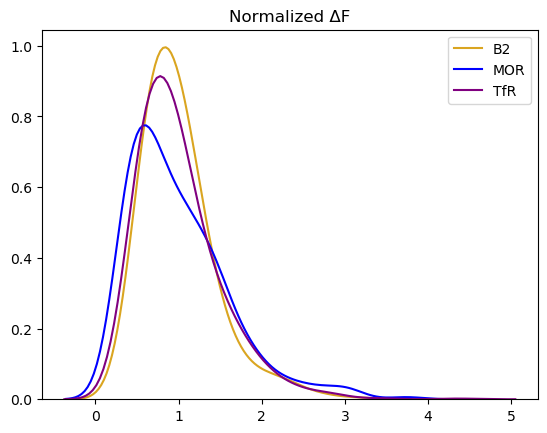

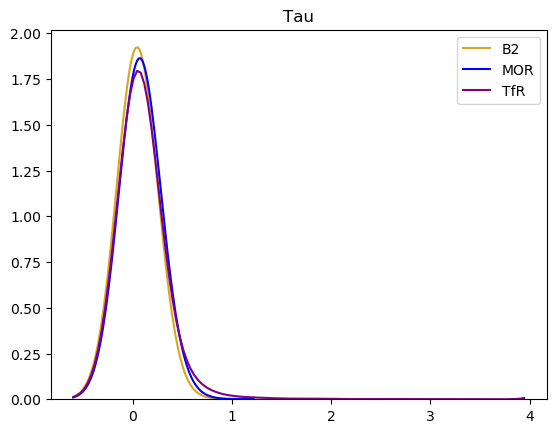

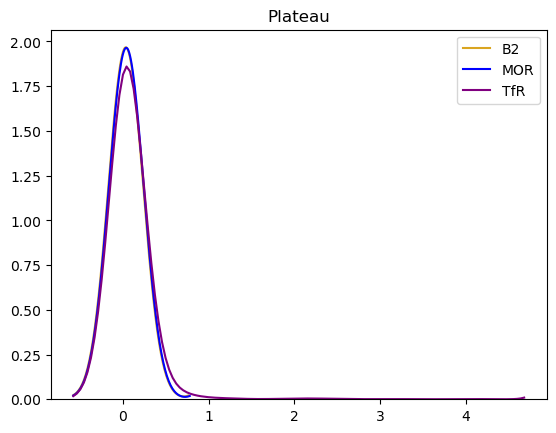

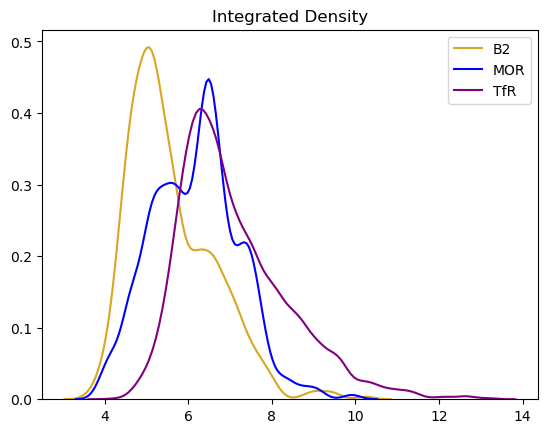

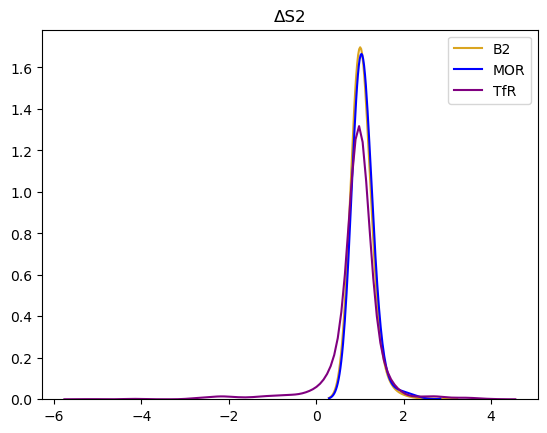

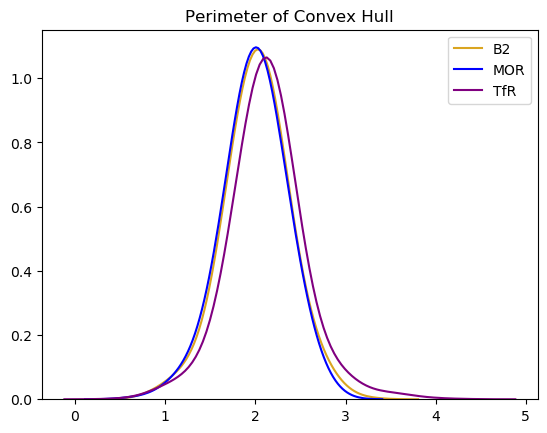

In [169]:
cargo_pal = sns.color_palette(['goldenrod', 'blue', 'purple'])
sns.set_palette(cargo_pal)

plt.figure()
for cargo in ['B2', 'MOR', 'TfR']:
    sns.kdeplot(np.log(labeled_sample.loc[(labeled_sample['puff'] == 1) &
                                   (labeled_sample['cargo'] == cargo),
                                   'lifetime_s']),
                label=cargo,
                bw=0.2)
plt.title('Lifetime')

plt.figure()
for cargo in ['B2', 'MOR', 'TfR']:
    subset = labeled_sample.loc[(labeled_sample['puff'] == 1) &
                                   (labeled_sample['cargo'] == cargo), :]
    deltafs = np.zeros(len(subset))
    for cell in np.unique(subset['cell']):
        deltaf = subset.loc[subset['cell'] == cell, 'deltaf']
        deltafs[subset['cell'] == cell] = deltaf/np.nanmean(deltaf)
    sns.kdeplot(deltafs,
                label=cargo,
                bw=0.2)
plt.title(u'Normalized ΔF')

plt.figure()
for cargo in ['B2', 'MOR', 'TfR']:
    sns.kdeplot(np.arcsinh(labeled_sample.loc[(labeled_sample['puff'] == 1) &
                                   (labeled_sample['cargo'] == cargo),
                                   'tau']),
                label=cargo,
                bw=0.2)
plt.title('Tau')

plt.figure()
for cargo in ['B2', 'MOR', 'TfR']:
    sns.kdeplot(np.arcsinh(labeled_sample.loc[(labeled_sample['puff'] == 1) &
                                   (labeled_sample['cargo'] == cargo),
                                   'plateau']),
                label=cargo,
                bw=0.2)
plt.title('Plateau')

plt.figure()
for cargo in ['B2', 'MOR', 'TfR']:
    sns.kdeplot(np.log(labeled_sample.loc[(labeled_sample['puff'] == 1) &
                                   (labeled_sample['cargo'] == cargo),
                                   'intden']),
                label=cargo,
                bw=0.2)
plt.title('Integrated Density')

plt.figure()
for cargo in ['B2', 'MOR', 'TfR']:
    sns.kdeplot(np.arcsinh(labeled_sample.loc[(labeled_sample['puff'] == 1) &
                                   (labeled_sample['cargo'] == cargo),
                                   'delta_s2']),
                label=cargo,
                bw=0.2)
plt.title(u'ΔS2')

plt.figure()
for cargo in ['B2', 'MOR', 'TfR']:
    sns.kdeplot(labeled_sample.loc[(labeled_sample['puff'] == 1) &
                                   (labeled_sample['cargo'] == cargo),
                                   'conv_perim'],
                label=cargo,
                bw=0.2)
plt.title('Perimeter of Convex Hull')

In [211]:
import sklearn.manifold
from sklearn import preprocessing

foi = ['lifetime_s', 'plateau', 'tau', 'intden', 'deltaf', 'delta_s2']

puffs_for_ds = labeled_sample.loc[labeled_sample['puff'] == 1., ['cargo', 'cell'] + foi]

for cell in np.unique(puffs_for_ds['cell']):
    for field in foi:
        dist = puffs_for_ds.loc[puffs_for_ds['cell'] == cell, field]
        if (np.max(dist) > 1):
            if np.any(dist <= 0):
                dist = np.arcsinh(dist)
            else:
                dist = np.log(dist)
                
        puffs_for_ds.loc[puffs_for_ds['cell'] == cell, field] = dist
    
    puffs_for_ds.loc[puffs_for_ds['cell'] == cell, foi] = preprocessing.scale(puffs_for_ds.loc[puffs_for_ds['cell'] == cell, foi])

In [225]:
t_start = time.time()
tsne_class = sklearn.manifold.TSNE(random_state=237)
fit_tsne = tsne_class.fit_transform(puffs_for_ds.loc[puffs_for_ds['cargo'] == 'TfR', foi])
print(str(time.time() - t_start))

18.09679913520813


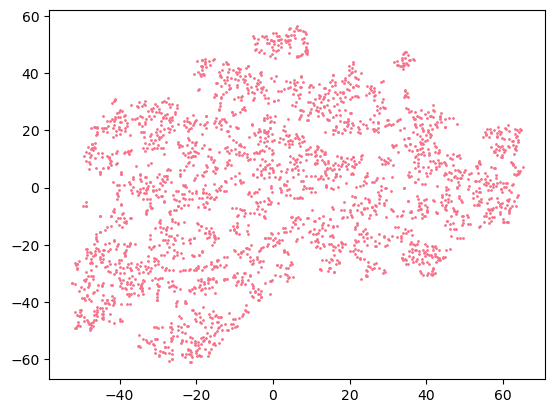

In [227]:
plt.scatter(fit_tsne[:,0], fit_tsne[:,1], s=1)

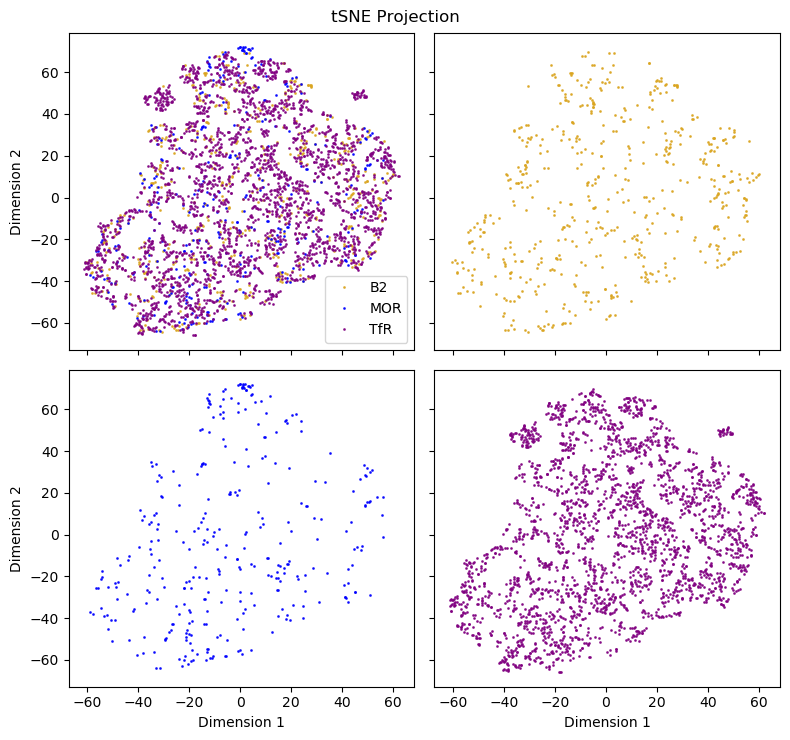

In [219]:
sns.set_palette(cargo_pal)

fig, axs = plt.subplots(2,2, figsize=(8,7.5), sharex = True, sharey = True)

axs = axs.ravel()

for axis, cargo in enumerate(['B2','MOR','TfR']):
    filt = (puffs_for_ds['cargo'] == cargo)
    axs[0].plot(fit_tsne[filt,0],
                fit_tsne[filt,1],
                marker='o', markersize='1', ls='None', alpha = .8, label=cargo)
    axs[axis+1].plot(fit_tsne[filt,0],
                   fit_tsne[filt,1],
                   marker='o', markersize='1', ls='None', alpha = .8, label=cargo, color=cargo_pal[axis])


axs[0].legend()
axs[0].set_ylabel('Dimension 2')
axs[2].set_ylabel('Dimension 2')
axs[3].set_xlabel('Dimension 1')
axs[2].set_xlabel('Dimension 1')
plt.suptitle('tSNE Projection')
plt.tight_layout(rect=[0,0, 1, 0.97])
plt.show()

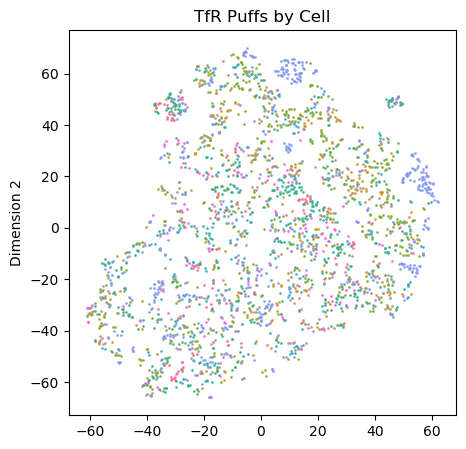

In [220]:
filt = (puffs_for_ds['cargo'] == 'TfR')
sns.set_palette(sns.color_palette("husl", len(np.unique(puffs_for_ds.loc[filt, 'cell']))))
fig = plt.figure(figsize = (5,5))
for cell in np.unique(puffs_for_ds.loc[filt, 'cell']):
    cell_filt = filt & (puffs_for_ds['cell'] == cell)
    plt.scatter(fit_tsne[cell_filt,0],
                fit_tsne[cell_filt,1],
                s=1,
                alpha =.8,
                label = cell)
plt.ylabel('Dimension 2')
plt.title('TfR Puffs by Cell')
plt.show()

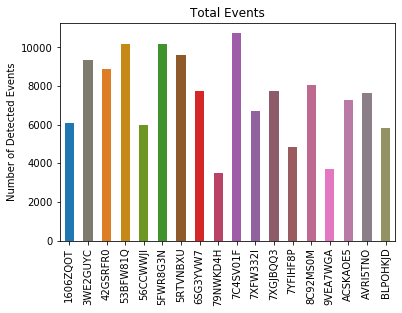

In [49]:
labeled_sample.groupby('cell')['particle'].count().plot.bar(x='cell', y='particle', color=cell_pal, legend = False)
plt.ylabel('Number of Detected Events')
plt.xlabel('')
plt.title('Total Events')
plt.show()

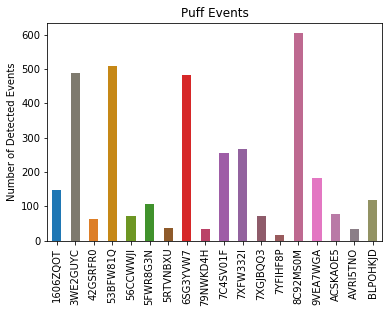

In [52]:
labeled_sample.loc[labeled_sample['puff'] == 1, :].groupby('cell')['particle'].count().plot.bar(x='cell', y='particle', color=cell_pal, legend = False)
plt.ylabel('Number of Detected Events')
plt.xlabel('')
plt.title('Puff Events')
plt.show()

That's a large range, but overall a small enough number of a events to be able to try training a clasffiier on all cells! Let's load in the features calculated for all these events:

In [24]:
print('%d puffs in %d events (%.4f puff rate)' % (np.sum(labeled_sample['puff']),
                                                  np.shape(labeled_sample)[0],
                                                  (np.sum(labeled_sample['puff'])/np.shape(labeled_sample)[0])))

3564 puffs in 134127 events (0.0266 puff rate)


This enrichment is at about the rate that we had seen previously with the 10Hz movies, which we were able to (in some cases) detect events. Cool! Let's try it!

## Classifier

With a puff sample detected, we can now generate a classifier trained on it. For this, we're using all of the cross-correlation features that Ciaran generated, as well as area and perimeter of the convex hull, plus event lifetime, total change in fluorescence over event lifetime, and time to reach half-max after maximum.

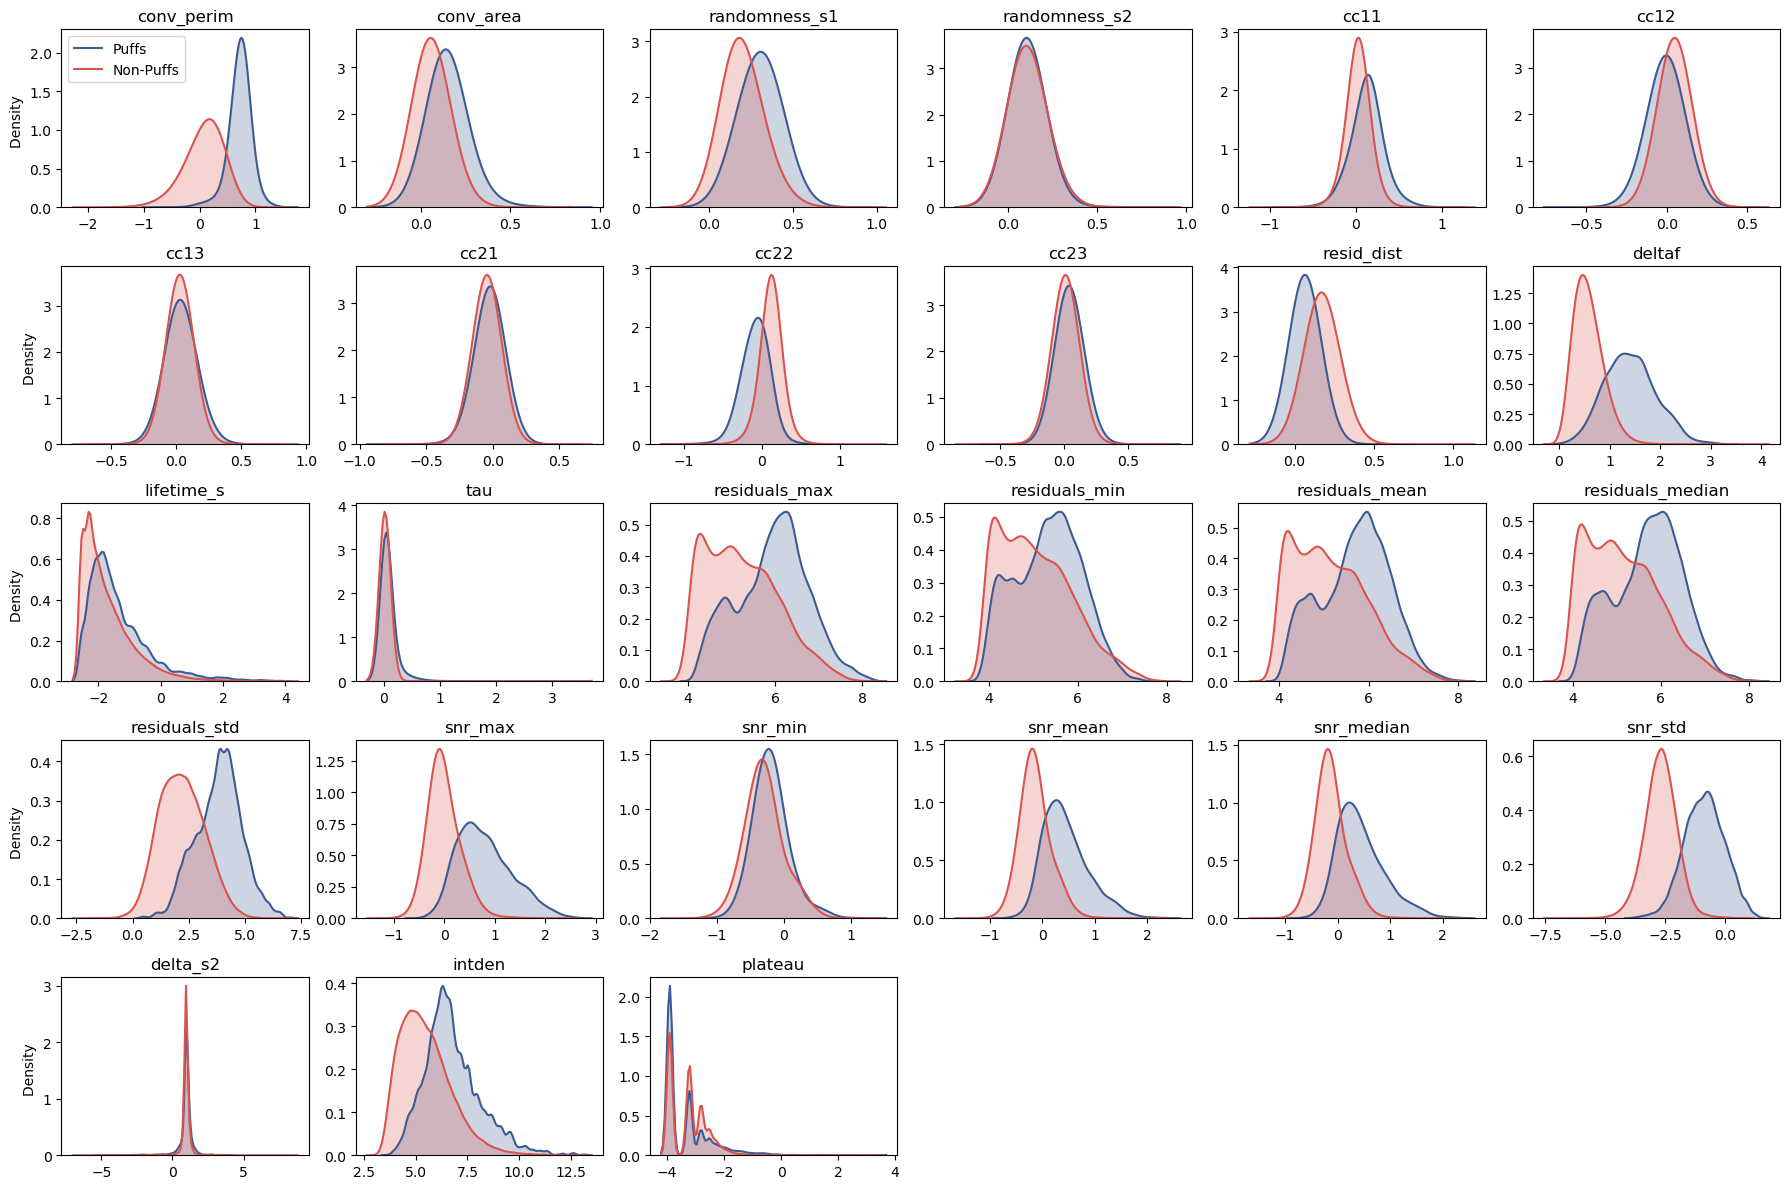

In [160]:
sns.set_palette(sns.color_palette([sns.xkcd_rgb['denim blue'], sns.xkcd_rgb['pale red']]))

nrows = 6
features = ['conv_perim', 'conv_area',
       'randomness_s1', 'randomness_s2', 'cc11', 'cc12', 'cc13', 'cc21',
       'cc22', 'cc23', 'resid_dist', 'deltaf', 'lifetime_s', 'tau', 'residuals_max', 'residuals_min',
       'residuals_mean', 'residuals_median', 'residuals_std', 'snr_max',
       'snr_min', 'snr_mean', 'snr_median', 'snr_std', 'delta_s2', 'intden', 'plateau']

fig, axes = plt.subplots(math.ceil(np.shape(features)[0]/nrows),
                         nrows)
fig.set_size_inches(18,12)
axes = axes.ravel()

for counter, feature in enumerate(features):
    if counter % nrows == 0:
        axes[counter].set_ylabel('Density ')
    axes[counter].set_title(feature)
    dist = labeled_sample[feature]
    puff_dist = dist[labeled_sample['puff'] == 1]
    nonpuff_dist = dist[labeled_sample['puff'] == 0]
    dist = dist[~np.isnan(dist)]
    puff_dist = puff_dist[~np.isnan(puff_dist)]
    nonpuff_dist = nonpuff_dist[~np.isnan(nonpuff_dist)]
    
    if (np.max(dist) > 1):
        if np.any(dist <= 0):
            sns.kdeplot(np.arcsinh(puff_dist), label = 'Puffs', bw = 0.1, shade = True,
                        ax = axes[counter], legend=None)
            sns.kdeplot(np.arcsinh(nonpuff_dist), label = 'Non-Puffs', bw = 0.1, shade = True,
                        ax = axes[counter], legend=None)
        else:
            sns.kdeplot(np.log(puff_dist), label = 'Puffs', bw = 0.1, shade = True,
                        ax = axes[counter], legend=None)
            sns.kdeplot(np.log(nonpuff_dist), label = 'Non-Puffs', bw = 0.1, shade = True,
                        ax = axes[counter], legend=None)
    else:
        sns.kdeplot(puff_dist, label = 'Puffs', bw = 0.1, shade = True,
                     ax = axes[counter], legend=None)
        sns.kdeplot(nonpuff_dist, label = 'Non-Puffs', bw = 0.1, shade = True,
                     ax = axes[counter], legend=None)

for idx in np.arange(counter+1,len(axes)):
    axes[idx].axis('off')
axes[0].legend()
plt.tight_layout()
sns.reset_defaults()

From these features, we selected a subet to actually fit the classifier on. 

The following is the evaluated OOB sample on a calssifier trained on all of the data. 

In [6]:
training_fields = ['conv_perim', 'conv_area', 'lifetime_s',
    'randomness_s1', 'randomness_s2', 'cc11', 'cc12', 'cc13', 'cc21',
    'cc22', 'cc23', 'deltaf', 'tau', 'resid_dist', 'residuals_median', 
    'residuals_std', 'snr_median', 'snr_std']

In [60]:
global_classifier = RandomForestClassifier(
    n_estimators = 2000, 
    oob_score = True, 
    class_weight="balanced", 
    random_state=237,
    min_samples_leaf=10,
    n_jobs=4)

global_classifier.fit(labeled_sample[training_fields], labeled_sample['puff'])

In [228]:
joblib.dump(global_classifier, 'global_classifier.joblib')

['global_classifier.joblib']

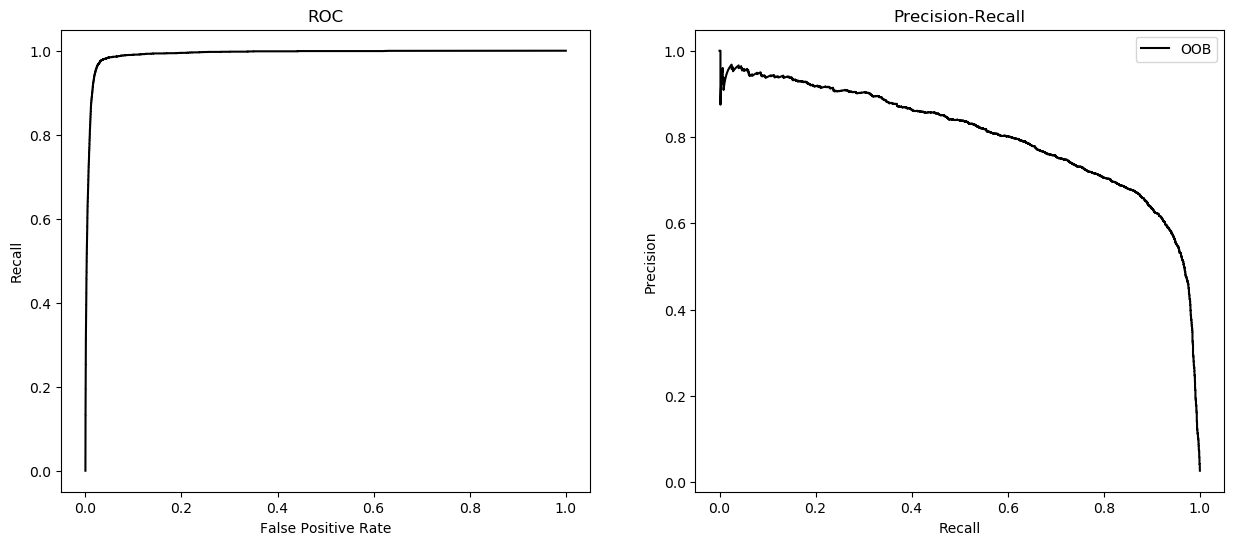

In [87]:
plt.figure(figsize=(15,6))
ax1 = plt.subplot(121)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('Recall')
ax1.set_title('ROC')
ax2 = plt.subplot(122)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall')
fpr, tpr , thresholds= roc_curve(labeled_sample['puff'], global_classifier.oob_decision_function_[:,1], pos_label = 1)
ax1.plot(fpr, tpr, label="OOB", color="k")
precision, recall, thresholds = precision_recall_curve(labeled_sample['puff'], global_classifier.oob_decision_function_[:,1],pos_label = 1)
ax2.plot(recall, precision, label="OOB", color="k")
plt.legend()

In [158]:
for feature, importance in zip(training_fields, global_classifier.feature_importances_):
    print("%s: %.5f" % (feature, importance))

conv_perim: 0.24012
conv_area: 0.07985
lifetime_s: 0.01845
randomness_s1: 0.03117
randomness_s2: 0.00679
cc11: 0.01160
cc12: 0.01364
cc13: 0.00588
cc21: 0.00683
cc22: 0.05669
cc23: 0.00661
deltaf: 0.01335
tau: 0.00478
resid_dist: 0.25387
residuals_median: 0.00758
residuals_std: 0.03802
snr_median: 0.04786
snr_std: 0.15690


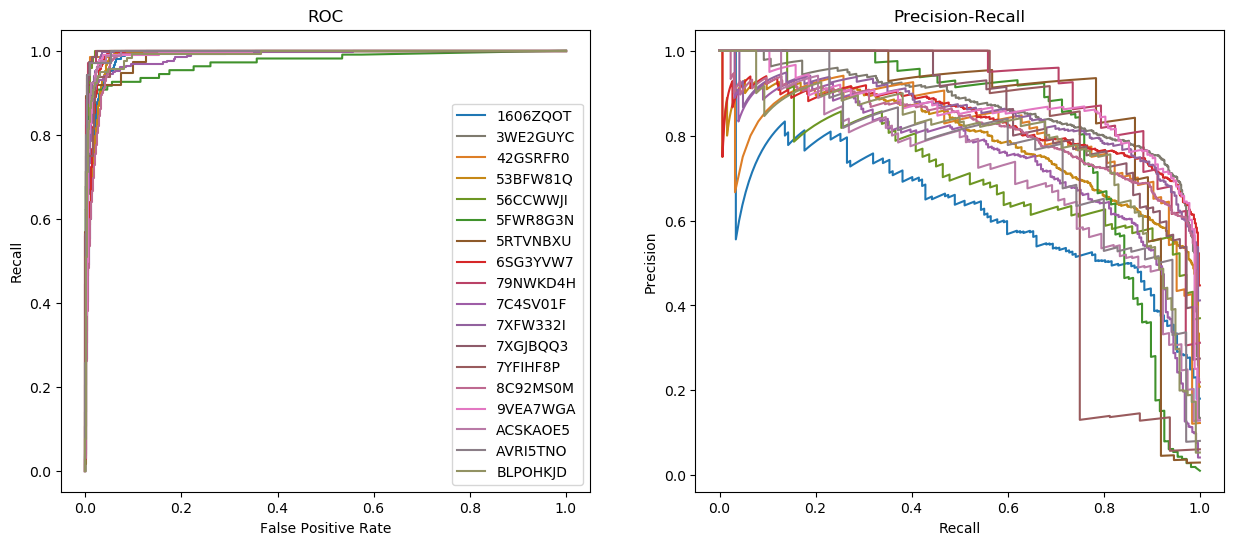

In [82]:
sns.set_palette(cell_pal)
plt.figure(figsize=(15,6))
ax1 = plt.subplot(121)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('Recall')
ax1.set_title('ROC')
ax2 = plt.subplot(122)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall')
for cell in cells:
    cell_filter = labeled_sample['cell'] == cell
    fpr, tpr , thresholds= roc_curve(labeled_sample['puff'][cell_filter], global_classifier.oob_decision_function_[cell_filter,1], pos_label = 1)
    ax1.plot(fpr, tpr, label=cell)
    precision, recall, thresholds = precision_recall_curve(labeled_sample['puff'][cell_filter], global_classifier.oob_decision_function_[cell_filter,1],pos_label = 1)
    ax2.plot(recall, precision, label=cell)
ax1.legend()

Distribution of predicted puffness for puffs and non-puffs:

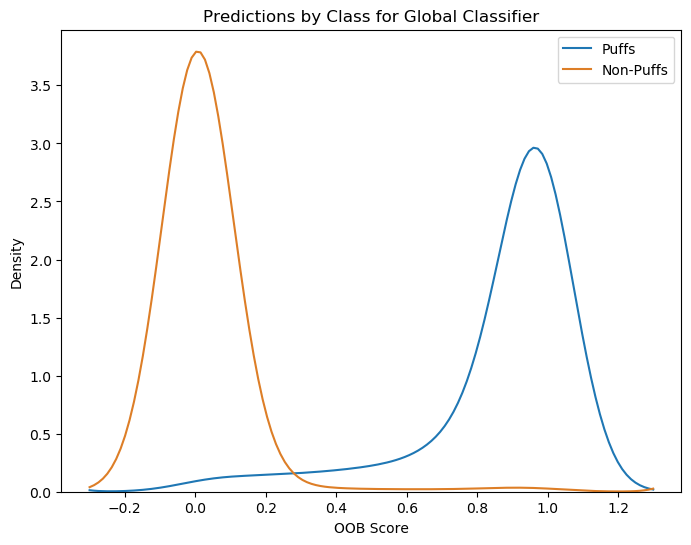

In [95]:
plt.figure(figsize=(8,6))
plt.title('Predictions by Class for Global Classifier')
plt.xlabel('OOB Score')
plt.ylabel('Density')
sns.kdeplot(global_classifier.oob_decision_function_[labeled_sample['puff'] == 1, 1], label="Puffs", bw=0.1, color="C0")
sns.kdeplot(global_classifier.oob_decision_function_[labeled_sample['puff'] == 0, 1], label="Non-Puffs", color="C2", bw=0.1)
plt.show()

## Calibration?

I hand-scored events from a random sampling of each cargo to generate calibration curves.

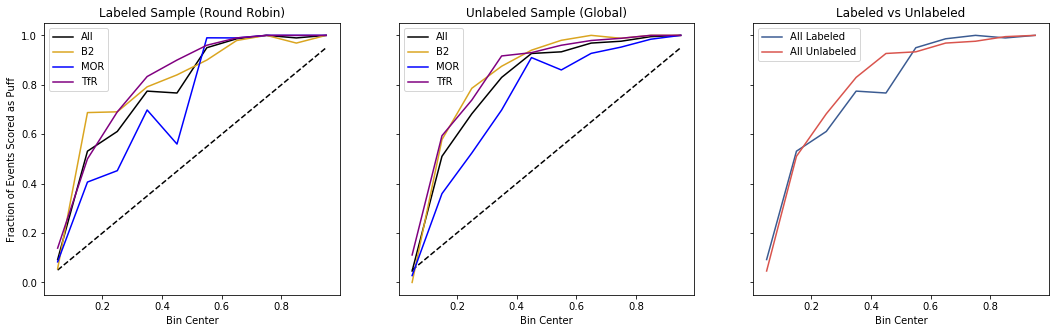

In [23]:
sns.set_palette(cargo_pal)

binned_samples = pd.read_csv('scored_binned_samples-20191121.csv', index_col=0)
binned_labeled_samples = pd.read_csv('binned_labeled_samples_20191121.csv', index_col=0)

bins = [[0, 0.1], [0.1, 0.2], [0.2, 0.3], [0.3, 0.4], [0.4, 0.5], [0.5, 0.6], [0.6, 0.7], [0.7, 0.8], [0.8, 0.9], [0.9, 1.0]]
n_samples = [36,  64,  84,  96, 100, 100,  96,  84,  64,  36]

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,5), sharey=True)

xs = [res for res in map(np.mean, bins)]

for ax, samples in zip(axs, [binned_labeled_samples, binned_samples]):
    ax.plot(xs, xs, linestyle='--', color='k')

    ys = []
    for idx, bin_ in enumerate(bins):
        binned_sample = samples[(bin_[0] <= samples['adj_proba'].values) &
                                       (samples['adj_proba'].values < bin_[1])]
        ys.append(np.sum(binned_sample['score'] == 1)/np.sum(binned_sample['score'] >= 0))
    ax.plot(xs, ys, label='All', color='k')

    for cargo in ['B2', 'MOR', 'TfR']:
        ys = []
        for idx, bin_ in enumerate(bins):
            binned_sample = samples[(bin_[0] <= samples['adj_proba'].values) &
                                           (samples['adj_proba'].values < bin_[1]) &
                                           (samples['cargo'] == cargo)]
            ys.append(np.sum(binned_sample['score'] == 1)/np.sum(binned_sample['score'] >= 0))
        ax.plot(xs, ys, label=cargo)

    ax.set_xlabel('Bin Center')
    ax.legend()

labeled_ys = []
unlabeled_ys = []
for idx, bin_ in enumerate(bins):
    labeled_sample = binned_labeled_samples[(bin_[0] <= binned_labeled_samples['adj_proba'].values) &
                                   (binned_labeled_samples['adj_proba'].values < bin_[1])]
    labeled_ys.append(np.sum(labeled_sample['score'] == 1)/np.sum(labeled_sample['score'] >= 0))
    
    unlabeled_sample = binned_samples[(bin_[0] <= binned_samples['adj_proba'].values) &
                                   (binned_samples['adj_proba'].values < bin_[1])]
    unlabeled_ys.append(np.sum(unlabeled_sample['score'] == 1)/np.sum(unlabeled_sample['score'] >= 0))

axs[2].plot(xs, labeled_ys, label='All Labeled', color=sns.xkcd_rgb['denim blue'])
axs[2].plot(xs, unlabeled_ys, label='All Unlabeled', color=sns.xkcd_rgb['pale red'])
axs[2].set_xlabel('Bin Center')
axs[0].set_ylabel('Fraction of Events Scored as Puff')
    
axs[0].set_title('Labeled Sample (Round Robin)')
axs[1].set_title('Unlabeled Sample (Global)')
axs[2].set_title('Labeled vs Unlabeled')
axs[2].legend()
plt.show()

Let's use a logistic GAM to build a calibrater based on this.

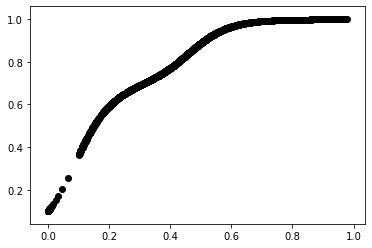

In [27]:
calibrater = LogisticGAM(s(0), n_splines=10).fit(binned_labeled_samples['adj_proba'].values,
                                   binned_labeled_samples['score'].values)

plt.scatter(binned_labeled_samples['adj_proba'].values, 
            calibrater.predict_proba(binned_labeled_samples['adj_proba'].values),
            color = 'k')

With that, how does our puff vs non-puff distribution change?

In [ ]:
plt.figure(figsize=(8,6))
calibrated_scores =
plt.title('Predictions by Class for Global Classifier')
plt.xlabel('OOB Score')
plt.ylabel('Density')
sns.kdeplot(global_classifier.oob_decision_function_[labeled_sample['puff'] == 1, 1], label="Puffs", bw=0.1, color="C0")
sns.kdeplot(global_classifier.oob_decision_function_[labeled_sample['puff'] == 0, 1], label="Non-Puffs", color="C2", bw=0.1)
plt.show()

In [63]:
# How many puffs/nonpuffs do we have with a high OOB probability?
cutoff = 0.5
nonpuff_idx = labeled_sample["puff"] == 0
nonpuff_oob = global_classifier.oob_decision_function_[nonpuff_idx,1]
puff_idx = labeled_sample["puff"] == 1
puff_oob = global_classifier.oob_decision_function_[puff_idx,1]
print("For a cutoff of %.2f, there are %d puffs and %d nonpuffs." % (cutoff, np.sum(puff_oob>cutoff), np.sum(nonpuff_oob>cutoff)))

For a cutoff of 0.50, there are 3267 puffs and 2029 nonpuffs.


/Volumes/Coatamer/Users/weinberz/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


1606ZQOT: 10204


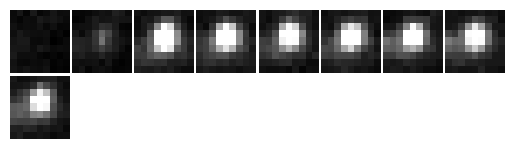

3WE2GUYC: 7945


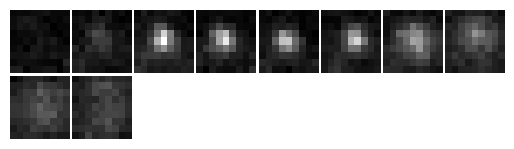

3WE2GUYC: 9474


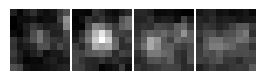

3WE2GUYC: 17699


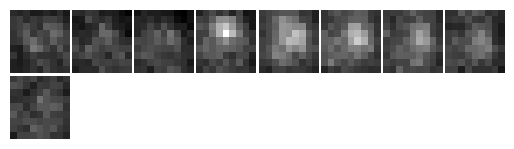

53BFW81Q: 3428


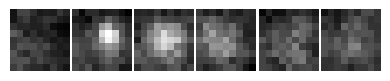

53BFW81Q: 17922


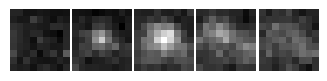

8C92MS0M: 4346


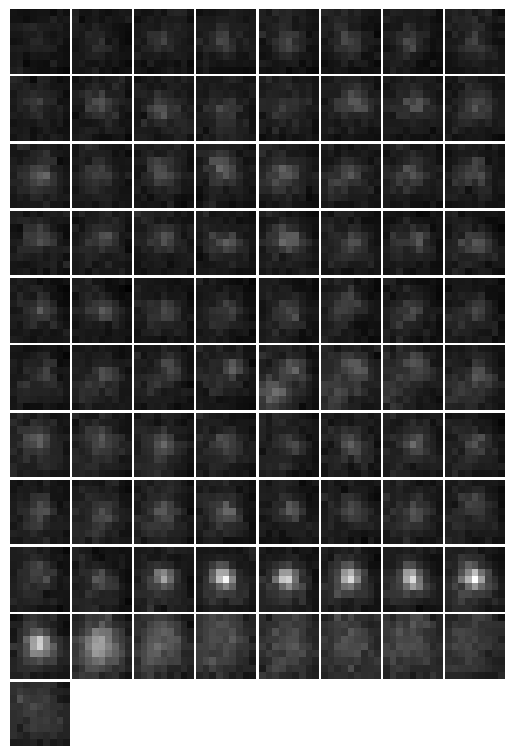

8C92MS0M: 10996


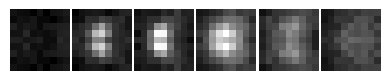

8C92MS0M: 13162


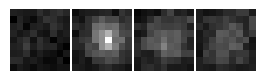

AVRI5TNO: 21


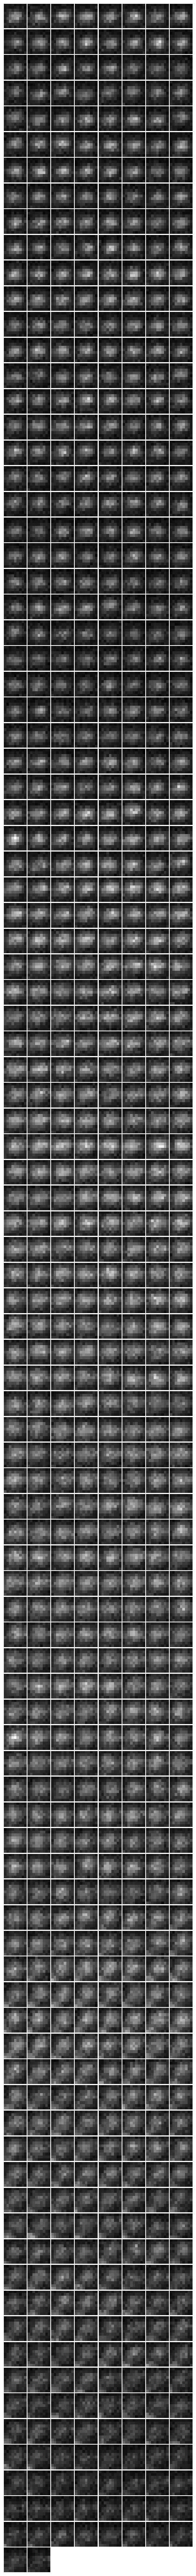

In [64]:
#Let's look at some random nonpuffs with high scores
high_np_idx = (labeled_sample["puff"] == 0) & (global_classifier.oob_decision_function_[:,1] > cutoff)
nonpuff_sample = labeled_sample.loc[high_np_idx,:]
nonpuff_sample = nonpuff_sample.iloc[np.random.choice(len(nonpuff_sample), size=10, replace=False),:]
for cell in np.unique(nonpuff_sample["cell"]):
    intensities = pd.read_csv('data/' + cell + ".tif_intensities.csv", index_col=0)
    subsample = nonpuff_sample.loc[nonpuff_sample["cell"] == cell, :]
    for particle in np.unique(subsample['particle']):
        frames = display.get_frames(intensities.loc[intensities['particle'] == particle,:])
        fig, axs = display.plot_montage(frames, figw=5, figh=0.875)
        print(cell + ": " + str(particle))
        plt.show()

In [132]:
#What about puffs with low probability?
cutoff = 0.01
nonpuff_idx = labeled_sample["puff"] == 0
nonpuff_oob = global_classifier.oob_decision_function_[nonpuff_idx,1]
puff_idx = labeled_sample["puff"] == 1
puff_oob = global_classifier.oob_decision_function_[puff_idx,1]
print("For a cutoff of %.2f, there are %d puffs and %d nonpuffs." % (cutoff, np.sum(puff_oob<cutoff), np.sum(nonpuff_oob<cutoff)))

For a cutoff of 0.01, there are 17 puffs and 102786 nonpuffs.


5FWR8G3N: 3960


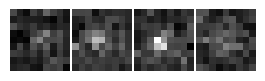

5FWR8G3N: 7336


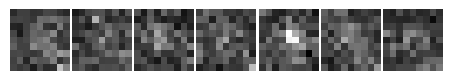

5FWR8G3N: 17561


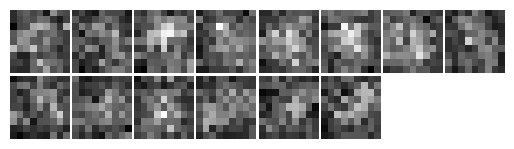

7C4SV01F: 1167


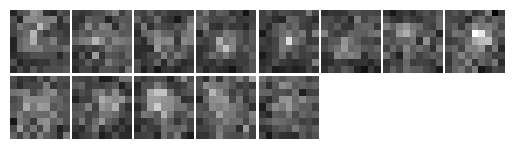

7C4SV01F: 1817


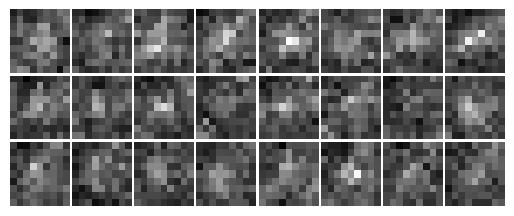

7C4SV01F: 12574


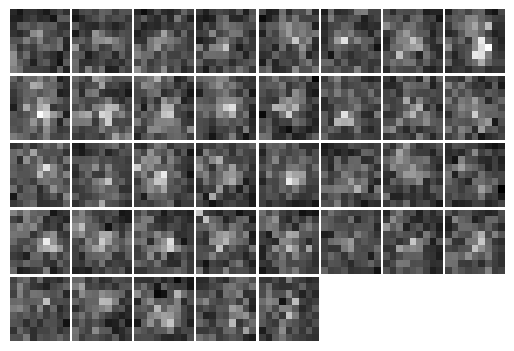

7C4SV01F: 21903


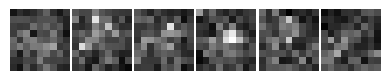

8C92MS0M: 1919


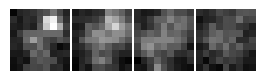

8C92MS0M: 5892


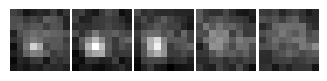

BLPOHKJD: 14158


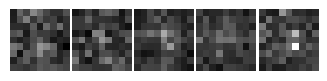

In [133]:
#Let's look at some random puffs with low scores
low_puff_idx = (labeled_sample["puff"] == 1) & (global_classifier.oob_decision_function_[:,1] < cutoff)
puff_sample = labeled_sample.loc[low_puff_idx,:]
puff_sample = puff_sample.iloc[np.random.choice(len(puff_sample), size=10, replace=False),:]
for cell in np.unique(puff_sample["cell"]):
    intensities = pd.read_csv('data/' + cell + ".tif_intensities.csv", index_col=0)
    subsample = puff_sample.loc[puff_sample["cell"] == cell, :]
    for particle in np.unique(subsample['particle']):
        frames = display.get_frames(intensities.loc[intensities['particle'] == particle,:])
        fig, axs = display.plot_montage(frames, figw=5, figh=0.875)
        print(cell + ": " + str(particle))
        plt.show()

That's not the worst! Do we improve if we restrict the lifetime of events? In this case, we're only including events that are greater than 10 frames in length.

Slight improvement, but not dramatic. What about the round-robin style classifier, trained on all data except one held-out cell?

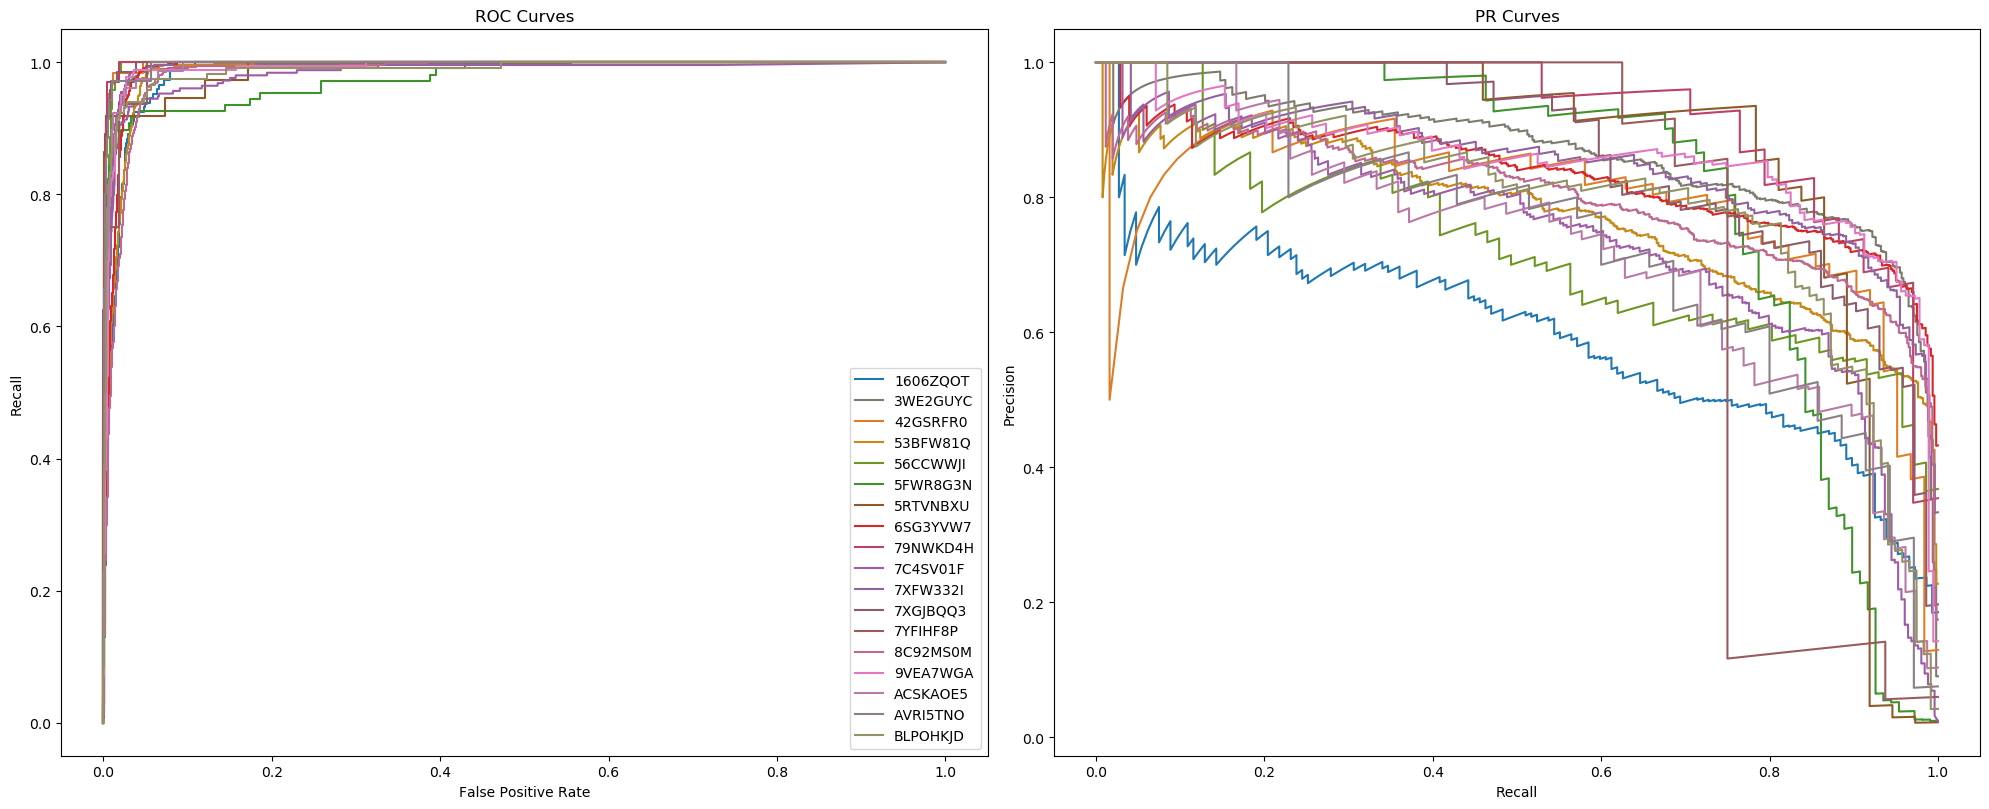

In [65]:
sns.set_palette(cell_pal)
plt.figure(figsize=(20,8.2))
ax1 = plt.subplot(121)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('Recall')
ax1.set_title('ROC Curves')
ax2 = plt.subplot(122)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('PR Curves')

rr_classifiers = {}

for cell in tqdm(np.unique(labeled_sample['cell'])):
    held_data = labeled_sample.loc[labeled_sample['cell'] == cell]
    train_data = labeled_sample.loc[labeled_sample['cell'] != cell]
    classifier = RandomForestClassifier(
        n_estimators = 2000, 
        oob_score = True, 
        class_weight="balanced", 
        random_state=237,
        min_samples_leaf=10,
        n_jobs=4)
    classifier.fit(train_data[training_fields], train_data['puff'])
    probas_ = classifier.predict_proba(held_data[training_fields])
    fpr, tpr , thresholds= roc_curve(held_data['puff'], probas_[:,1], pos_label = 1)
    ax1.plot(fpr, tpr, label=cell)
    precision, recall, thresholds = precision_recall_curve(held_data['puff'], probas_[:,1],pos_label = 1)
    ax2.plot(recall, precision, label=cell)
    labeled_sample.loc[labeled_sample['cell'] == cell, 'proba'] = probas_[:,1]
    rr_classifiers[cell] = classifier
                             
ax1.legend()
plt.tight_layout()
plt.show()

That performance is pretty variable, but decent on some cells! What about with regards to puff populations?

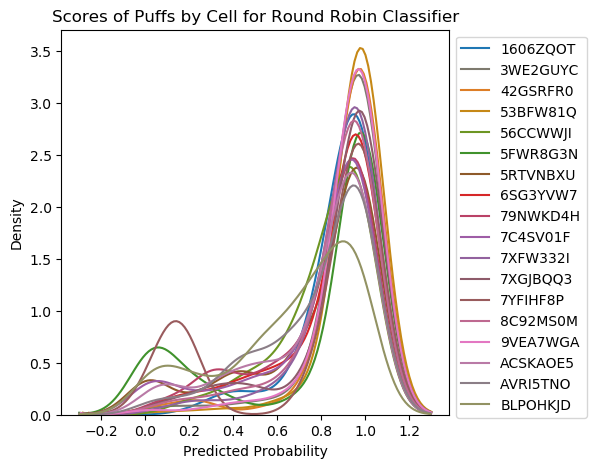

In [113]:
g = plt.figure(figsize=(5,5))
for cell in np.unique(labeled_sample['cell']):
    sns.kdeplot(labeled_sample.loc[(labeled_sample['cell'] == cell) &
                                   (labeled_sample['puff'] == 1), 'proba'].values, label=cell, bw=0.1)

plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.title('Scores of Puffs by Cell for Round Robin Classifier')
plt.show()

In [105]:
puff_performance = {}

for cell in cells:
    puff_performance[cell] = np.mean(labeled_sample.loc[(labeled_sample['cell'] == cell) &
                                                        (labeled_sample['puff'] == 1), 'proba'].values)
    
[(k, puff_performance[k]) for k in sorted(puff_performance, key=puff_performance.get, reverse=True)]

[('53BFW81Q', 0.9453392615339374),
 ('9VEA7WGA', 0.9175089410138308),
 ('42GSRFR0', 0.9146282569459104),
 ('3WE2GUYC', 0.9102091135666586),
 ('1606ZQOT', 0.8803780971083217),
 ('7XFW332I', 0.8767732253548804),
 ('7XGJBQQ3', 0.8636205604817463),
 ('8C92MS0M', 0.8511380948531525),
 ('6SG3YVW7', 0.8325108470786492),
 ('56CCWWJI', 0.8175239506787626),
 ('79NWKD4H', 0.7964121758488987),
 ('AVRI5TNO', 0.7803111604983778),
 ('7C4SV01F', 0.7730978161943121),
 ('5RTVNBXU', 0.7693625265898789),
 ('ACSKAOE5', 0.768935128712282),
 ('5FWR8G3N', 0.7557780441237048),
 ('7YFIHF8P', 0.7477231316144016),
 ('BLPOHKJD', 0.6705276149540379)]

There are definitely some cells where we do not do a good job of estimating puffs, but overall this is looking pretty compelling. Let's see if we can make it even better by accomplishing some form of covariate shit calculation.

## Covariate Shift

Trying to implement covariate shift on a cell comparison level requires some metric of cell similarity. Here, I'm going to try two approaches:

- Compute this metric directly: For each cell, train a classifier to discern between events from that cell and from all other cells.
- Compute this metric from classifier scores: For each cell, train a classifier from all other cells and then compare the held out cell's $\hat{y}$ with the OOB probability distribution for each of the cells that the classifier was trained on.

Let's start with the direct comparison metric, using a test case for a single cell:

In [67]:
target_cell = np.unique(labeled_sample['cell'])[1]
train_data = labeled_sample.loc[:, ['cell'] + training_fields]
train_data['cell_id'] = (train_data['cell'] == target_cell).astype(int)
classifier = RandomForestClassifier(
    n_estimators = 2000, 
    oob_score = True, 
    class_weight="balanced", 
    random_state=237,
    min_samples_leaf=10,
    n_jobs=4)
classifier.fit(train_data[training_fields], train_data['cell_id'])

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=10,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=2000, n_jobs=4, oob_score=True,
                       random_state=237, verbose=0, warm_start=False)

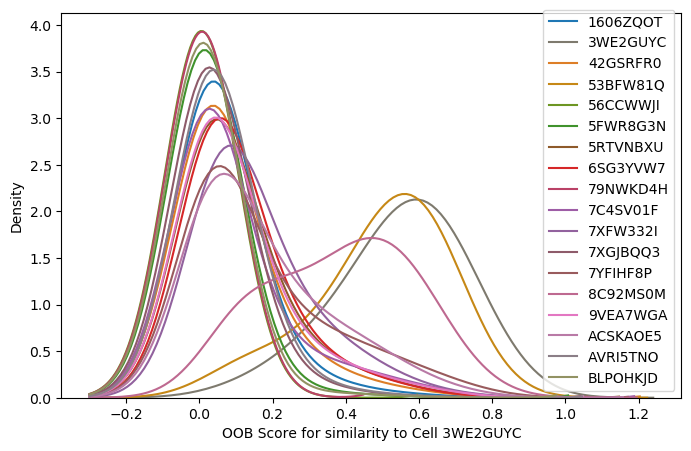

In [68]:
plt.figure(figsize=(8,5))
for output_cell in np.unique(labeled_sample['cell']):
    sns.kdeplot(classifier.oob_decision_function_[labeled_sample['cell'] == output_cell, 1], label=output_cell, bw=0.1)
plt.ylabel('Density')
plt.xlabel('OOB Score for similarity to Cell %s' % target_cell)
plt.show()

We can see that there are clearly some cells that look similar to our target cell, `3WE2GUYC`. How do we measure that similarity? Trivially, we can look at the earth mover's distance between the distribution. We can also look at the similarity in the means of the two distributions. Here's what this looks like for this example:

In [69]:
for cell in cells:
    distance = wd(classifier.oob_decision_function_[labeled_sample['cell'] == target_cell, 1],
                  classifier.oob_decision_function_[labeled_sample['cell'] == cell, 1])
    mean_similarity = (np.mean(classifier.oob_decision_function_[labeled_sample['cell'] == cell, 1])/
                       np.mean(classifier.oob_decision_function_[labeled_sample['cell'] == target_cell, 1]))
    print("%s has an inverse distance of %.5f and and a mean similarity of %.5f to cell %s" % 
          (cell, np.abs(1-distance), mean_similarity, target_cell))

1606ZQOT has an inverse distance of 0.51647 and and a mean similarity of 0.11853 to cell 3WE2GUYC
3WE2GUYC has an inverse distance of 1.00000 and and a mean similarity of 1.00000 to cell 3WE2GUYC
42GSRFR0 has an inverse distance of 0.53416 and and a mean similarity of 0.15078 to cell 3WE2GUYC
53BFW81Q has an inverse distance of 0.94632 and and a mean similarity of 0.90214 to cell 3WE2GUYC
56CCWWJI has an inverse distance of 0.45763 and and a mean similarity of 0.01126 to cell 3WE2GUYC
5FWR8G3N has an inverse distance of 0.47579 and and a mean similarity of 0.04438 to cell 3WE2GUYC
5RTVNBXU has an inverse distance of 0.55162 and and a mean similarity of 0.18261 to cell 3WE2GUYC
6SG3YVW7 has an inverse distance of 0.55858 and and a mean similarity of 0.19531 to cell 3WE2GUYC
79NWKD4H has an inverse distance of 0.45929 and and a mean similarity of 0.01429 to cell 3WE2GUYC
7C4SV01F has an inverse distance of 0.53861 and and a mean similarity of 0.15889 to cell 3WE2GUYC
7XFW332I has an inve

The inverse distance metric (i.e. $|1-EMD|$ seems to have a tighter range. Let's try weighting in the round for that.

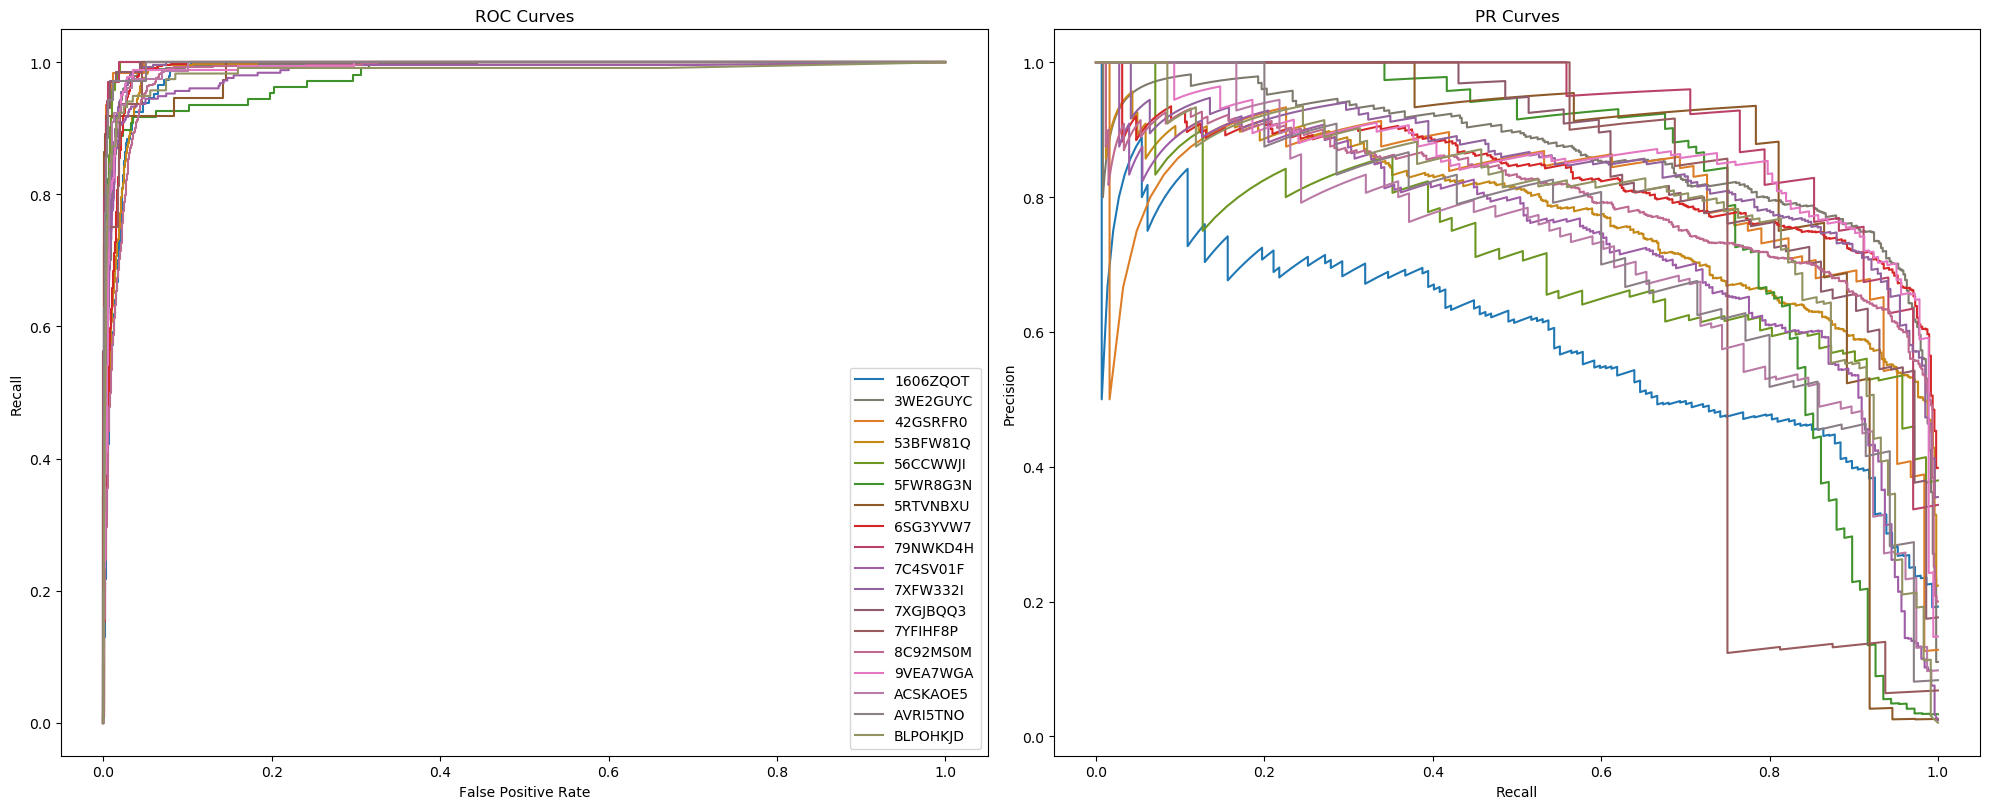

In [70]:
plt.figure(figsize=(20,8.2))
ax1 = plt.subplot(121)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('Recall')
ax1.set_title('ROC Curves')
ax2 = plt.subplot(122)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('PR Curves')

weighted_rr_classifiers = {}

for target_cell in tqdm(cells):
    #first, train the similarity classifier:
    train_data = labeled_sample.loc[:, ['cell'] + training_fields]
    train_data['cell_id'] = (train_data['cell'] == target_cell).astype(int)
    sim_classifier = RandomForestClassifier(
        n_estimators = 2000, 
        oob_score = True, 
        class_weight="balanced", 
        random_state=237,
        min_samples_leaf=10,
        n_jobs=4)
    sim_classifier.fit(train_data[training_fields], train_data['cell_id'])
    
    # Calculate weights as abs(1-EMD) off OOB probabilities
    weights = np.zeros(len(labeled_sample))
    for cell in cells:
        distance = wd(sim_classifier.oob_decision_function_[labeled_sample['cell'] == target_cell, 1],
                      sim_classifier.oob_decision_function_[labeled_sample['cell'] == cell, 1])
        weights[labeled_sample['cell'] == cell] = np.abs(1-distance)
    weights = weights[labeled_sample['cell'] != target_cell]    
    
    # Train classifier on weighted training data
    held_data = labeled_sample.loc[labeled_sample['cell'] == target_cell]
    train_data = labeled_sample.loc[labeled_sample['cell'] != target_cell]
    classifier = RandomForestClassifier(
        n_estimators = 2000, 
        oob_score = True, 
        class_weight="balanced", 
        random_state=237,
        min_samples_leaf=10,
        n_jobs=4)
    classifier.fit(train_data[training_fields], train_data['puff'], sample_weight = weights)
    probas_ = classifier.predict_proba(held_data[training_fields])
    fpr, tpr , thresholds= roc_curve(held_data['puff'], probas_[:,1], pos_label = 1)
    ax1.plot(fpr, tpr, label=target_cell)
    precision, recall, thresholds = precision_recall_curve(held_data['puff'], probas_[:,1],pos_label = 1)
    ax2.plot(recall, precision, label=target_cell)
    labeled_sample.loc[labeled_sample['cell'] == target_cell, 'weighted_proba'] = probas_[:,1]
    classifier_dict = {'classifier' : classifier,
                       'weights' : weights} 
    weighted_rr_classifiers[target_cell] = classifier_dict
                             
ax1.legend()
plt.tight_layout()
plt.show()

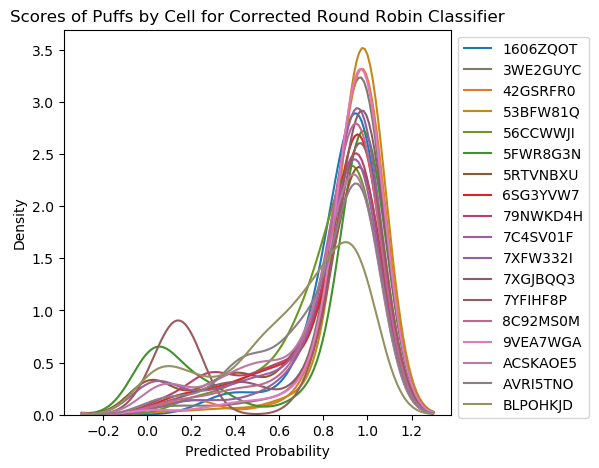

In [112]:
sns.set_palette(cell_pal)
g = plt.figure(figsize=(5,5))
for cell in cells:
    sns.kdeplot(labeled_sample.loc[(labeled_sample['cell'] == cell) &
                                   (labeled_sample['puff'] == 1), 'weighted_proba'].values, label=cell, bw=0.1)
    
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.title('Scores of Puffs by Cell for Corrected Round Robin Classifier')
plt.show()

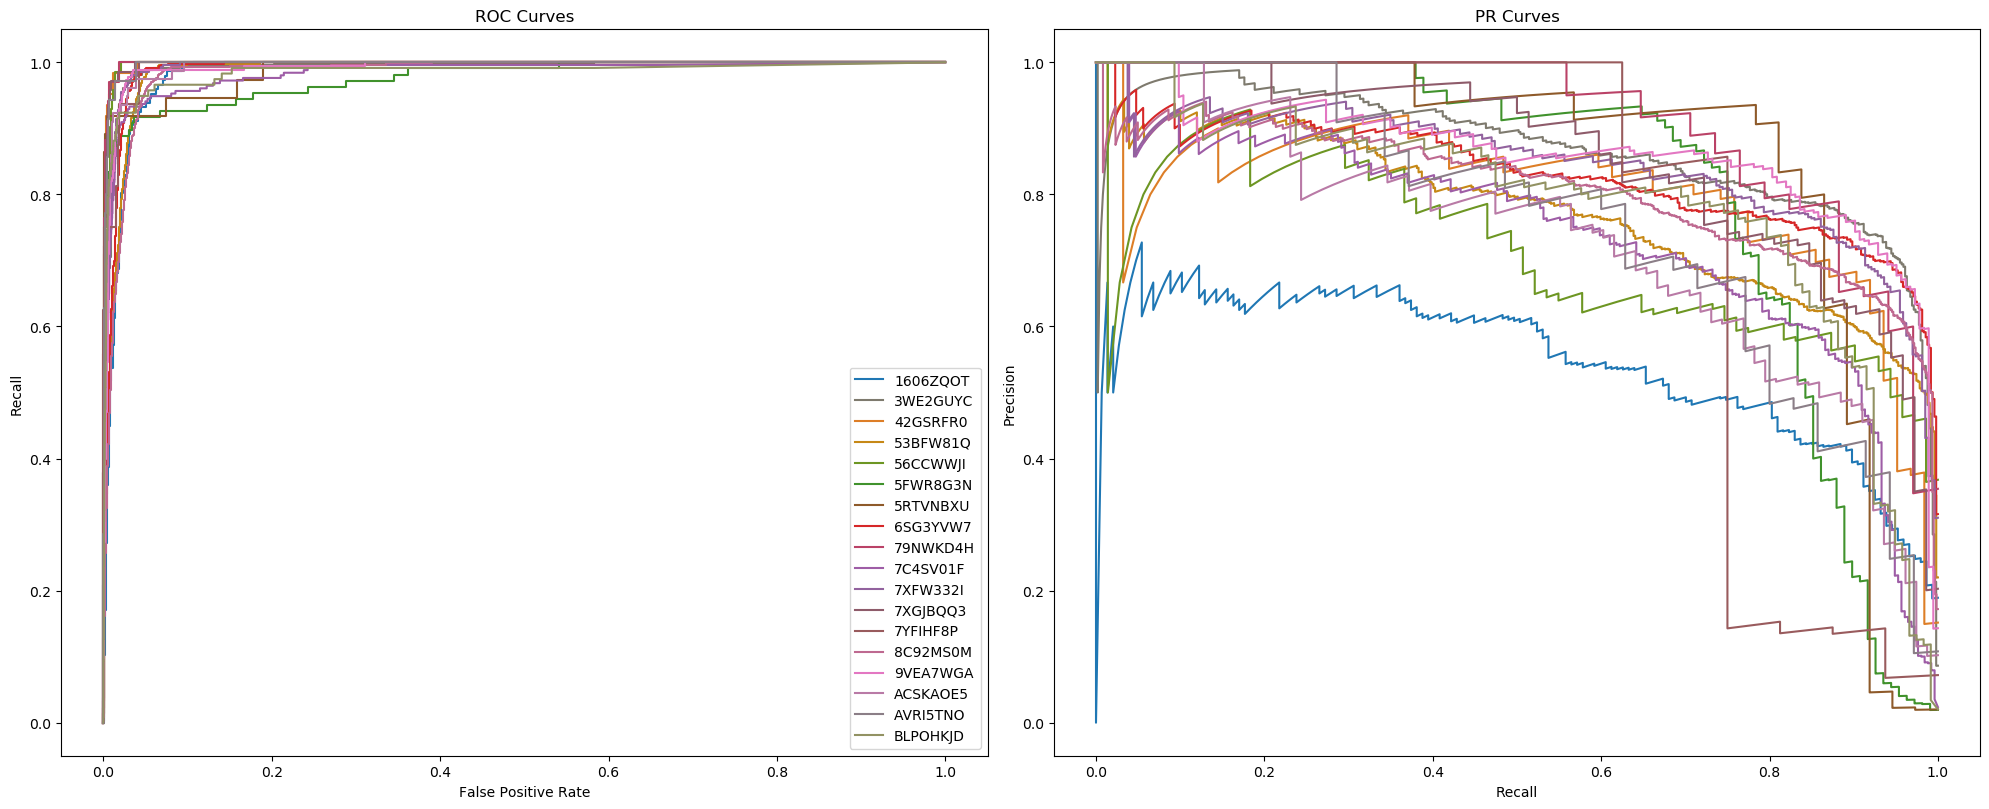

In [72]:
plt.figure(figsize=(20,8.2))
ax1 = plt.subplot(121)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('Recall')
ax1.set_title('ROC Curves')
ax2 = plt.subplot(122)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('PR Curves')

weighted_rr_classifiers = {}

for target_cell in tqdm(cells):
    #first, train the similarity classifier:
    train_data = labeled_sample.loc[:, ['cell'] + training_fields]
    train_data['cell_id'] = (train_data['cell'] == target_cell).astype(int)
    sim_classifier = RandomForestClassifier(
        n_estimators = 2000, 
        oob_score = True, 
        class_weight="balanced", 
        random_state=237,
        min_samples_leaf=10,
        n_jobs=4)
    sim_classifier.fit(train_data[training_fields], train_data['cell_id'])
    
    # Calculate weights as abs(1-EMD) off OOB probabilities
    weights = np.zeros(len(labeled_sample))
    for cell in cells:
        mean_similarity = (np.mean(sim_classifier.oob_decision_function_[labeled_sample['cell'] == cell, 1])/
                           np.mean(sim_classifier.oob_decision_function_[labeled_sample['cell'] == target_cell, 1]))
        weights[labeled_sample['cell'] == cell] = mean_similarity
    weights = weights[labeled_sample['cell'] != target_cell]    
    
    # Train classifier on weighted training data
    held_data = labeled_sample.loc[labeled_sample['cell'] == target_cell]
    train_data = labeled_sample.loc[labeled_sample['cell'] != target_cell]
    classifier = RandomForestClassifier(
        n_estimators = 2000, 
        oob_score = True, 
        class_weight="balanced", 
        random_state=237,
        min_samples_leaf=10,
        n_jobs=4)
    classifier.fit(train_data[training_fields], train_data['puff'], sample_weight = weights)
    probas_ = classifier.predict_proba(held_data[training_fields])
    fpr, tpr , thresholds= roc_curve(held_data['puff'], probas_[:,1], pos_label = 1)
    ax1.plot(fpr, tpr, label=target_cell)
    precision, recall, thresholds = precision_recall_curve(held_data['puff'], probas_[:,1],pos_label = 1)
    ax2.plot(recall, precision, label=target_cell)
    labeled_sample.loc[labeled_sample['cell'] == target_cell, 'weighted_mean_proba'] = probas_[:,1]
    classifier_dict = {'classifier' : classifier,
                       'weights' : weights} 
    weighted_rr_classifiers[target_cell] = classifier_dict
                             
ax1.legend()
plt.tight_layout()
plt.show()

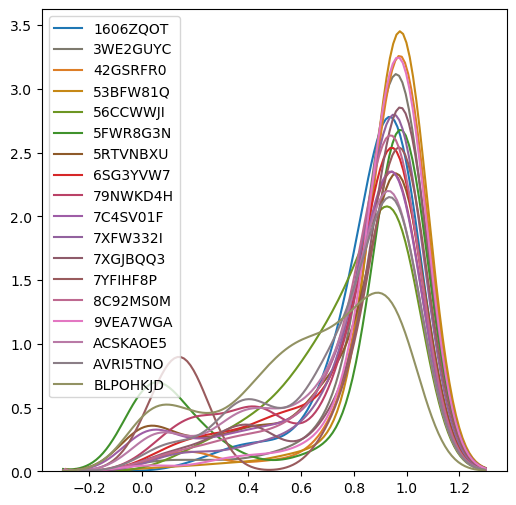

In [73]:
g = plt.figure(figsize=(6,6))
for cell in cells:
    sns.kdeplot(labeled_sample.loc[(labeled_sample['cell'] == cell) &
                                   (labeled_sample['puff'] == 1), 'weighted_mean_proba'].values, label=cell, bw=0.1)

Hmmmm - that seems to have a marginal effect at best. Let's try a distinct measure. Instead of picking similarity via a classifier with two classes (target and non-target) let's train a classifier to differentiate between held-out cells (so, 17 different classes) and then judge similarity based on the new input. This has the added bonus of having a stable classifier that can be reused, instead of having to build a new "to-target" classifier every time.

In [116]:
target_cell = np.unique(labeled_sample['cell'])[1]
train_data = labeled_sample.loc[labeled_sample['cell'] != target_cell, ['cell'] + training_fields]

classifier = RandomForestClassifier(
    n_estimators = 2000, 
    oob_score = True, 
    class_weight="balanced", 
    random_state=237,
    min_samples_leaf=10,
    n_jobs=4)
classifier.fit(train_data[training_fields], train_data['cell'])
proba = classifier.predict_proba(labeled_sample.loc[labeled_sample['cell'] == target_cell, training_fields])

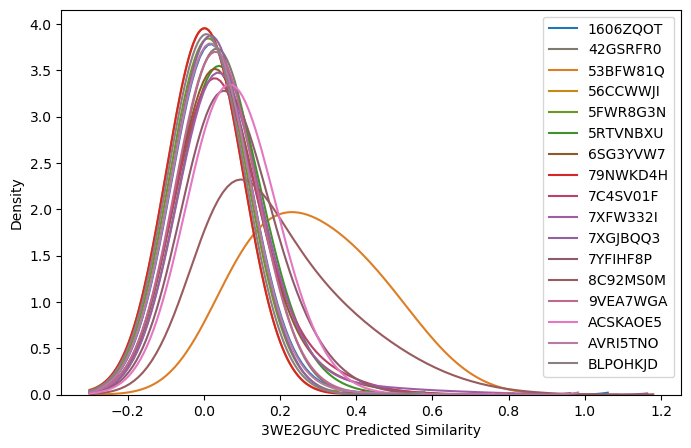

In [121]:
plt.figure(figsize=(8,5))
for idx, output_cell in enumerate(classifier.classes_):
    sns.kdeplot(proba[:, idx], label=output_cell, bw=0.1)
plt.ylabel('Density')
plt.xlabel('%s Predicted Similarity' % target_cell)
plt.show()

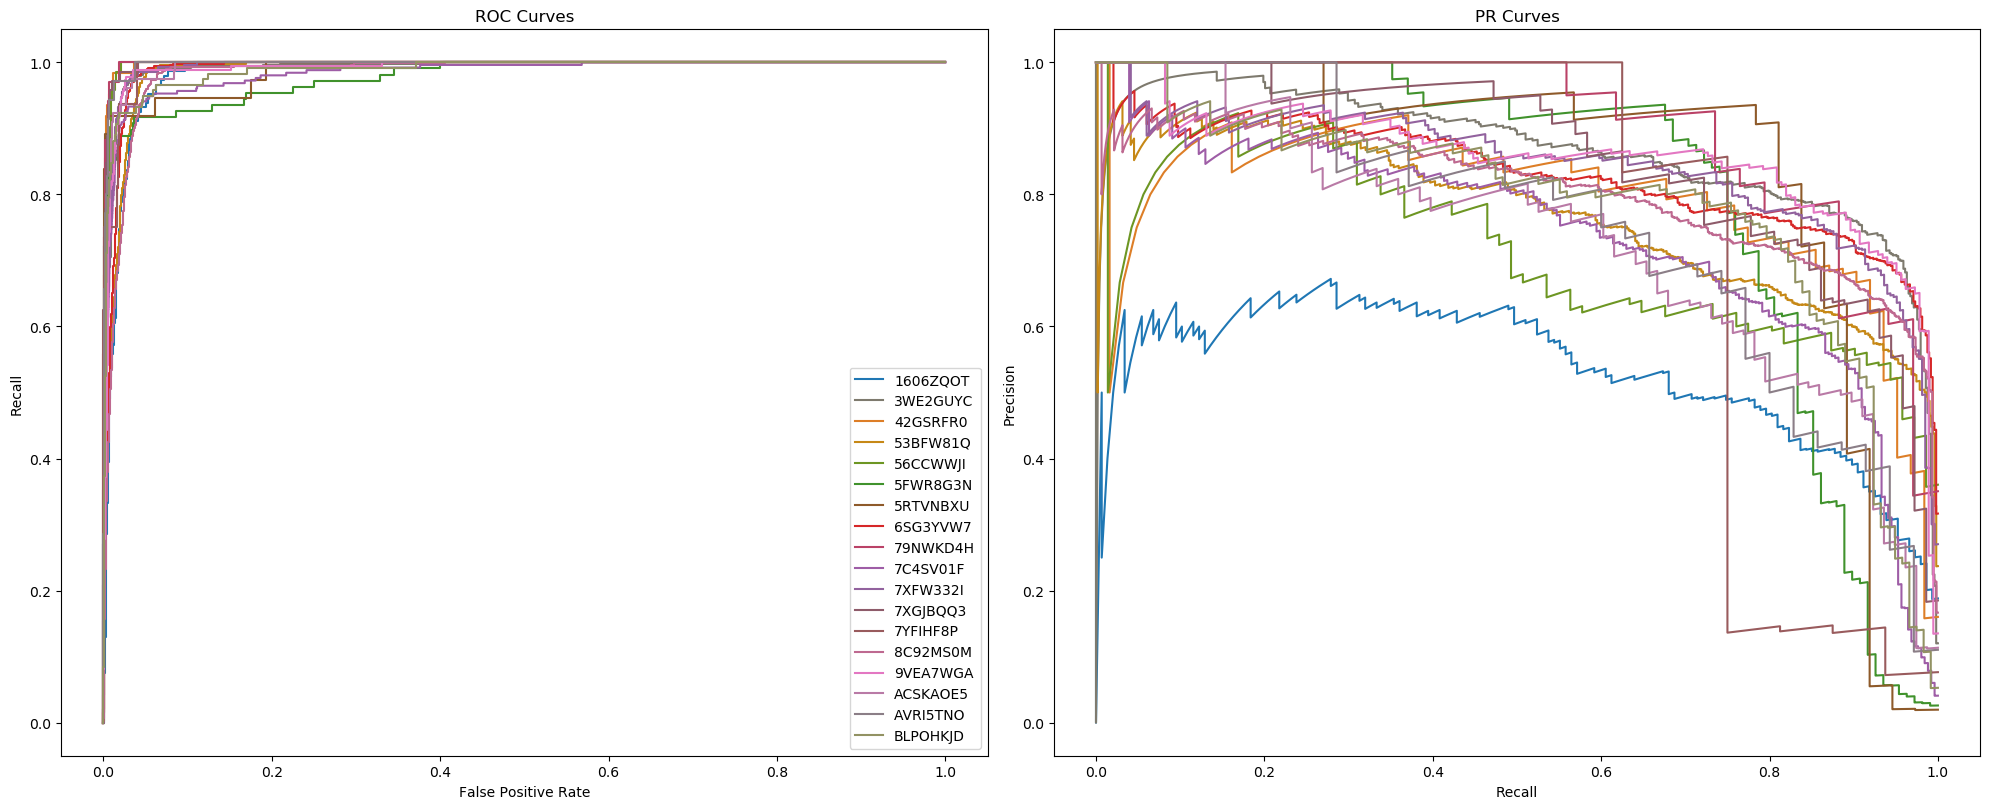

In [124]:
plt.figure(figsize=(20,8.2))
ax1 = plt.subplot(121)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('Recall')
ax1.set_title('ROC Curves')
ax2 = plt.subplot(122)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('PR Curves')

weighted_rr_classifiers = {}

for target_cell in tqdm(cells):
    #first, train the similarity classifier:
    train_data = labeled_sample.loc[labeled_sample['cell'] != target_cell, ['cell'] + training_fields]

    sim_classifier = RandomForestClassifier(
        n_estimators = 2000, 
        oob_score = True, 
        class_weight="balanced", 
        random_state=237,
        min_samples_leaf=10,
        n_jobs=4)
    sim_classifier.fit(train_data[training_fields], train_data['cell'])
    sim_proba = sim_classifier.predict_proba(labeled_sample.loc[labeled_sample['cell'] == target_cell, training_fields])
    
    # Train classifier on weighted training data
    held_data = labeled_sample.loc[labeled_sample['cell'] == target_cell]
    train_data = labeled_sample.loc[labeled_sample['cell'] != target_cell]
    classifier = RandomForestClassifier(
        n_estimators = 2000, 
        oob_score = True, 
        class_weight="balanced", 
        random_state=237,
        min_samples_leaf=10,
        n_jobs=4)
    
    # Calculate weights as mean predicted proba for each class:
    weights = np.zeros(len(train_data))
    for idx, output_cell in enumerate(sim_classifier.classes_):
        weights[train_data['cell'] == output_cell] = np.mean(sim_proba[:,idx])
    
    classifier.fit(train_data[training_fields], train_data['puff'], sample_weight = weights)
    probas_ = classifier.predict_proba(held_data[training_fields])
    fpr, tpr , thresholds= roc_curve(held_data['puff'], probas_[:,1], pos_label = 1)
    ax1.plot(fpr, tpr, label=target_cell)
    precision, recall, thresholds = precision_recall_curve(held_data['puff'], probas_[:,1],pos_label = 1)
    ax2.plot(recall, precision, label=target_cell)
    labeled_sample.loc[labeled_sample['cell'] == target_cell, 'weighted_proba'] = probas_[:,1]
    classifier_dict = {'classifier' : classifier,
                       'weights' : weights} 
    weighted_rr_classifiers[target_cell] = classifier_dict
                             
ax1.legend()
plt.tight_layout()
plt.show()

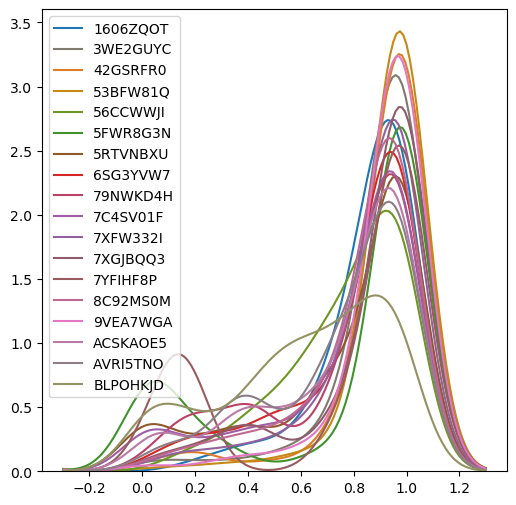

In [125]:
g = plt.figure(figsize=(6,6))
for cell in cells:
    sns.kdeplot(labeled_sample.loc[(labeled_sample['cell'] == cell) &
                                   (labeled_sample['puff'] == 1), 'weighted_proba'].values, label=cell, bw=0.1)

In [31]:
labeled_sample[['proba', 'weighted_proba', 'weighted_mean_proba']].head()

proba  weighted_proba  weighted_mean_proba
0  0.061576        0.066113             0.071336
1  0.134980        0.139517             0.141170
2  0.183758        0.177108             0.199014
3  0.605014        0.608534             0.570350
4  0.109906        0.105903             0.115522

In [60]:
scores_for_thresh = []

for cell in np.unique(labeled_sample['cell']):
    puffs = labeled_sample.loc[labeled_sample['cell'] == cell, 'puff'].values
    probas = labeled_sample.loc[labeled_sample['cell'] == cell, 'proba'].values
    for thresh in [0.2, 0.4, 0.6, 0.8]:
        f1 = f1_score(puffs, probas>thresh)
        puff_freq = np.sum(puffs) / len(puffs)
        num_puffs = np.sum(puffs)
        scores_for_thresh.append({'cell' : cell,
                                  'puff_freq' : puff_freq,
                                  'num_puffs' : num_puffs,
                                  'threshold' : thresh,
                                  'f1_score': f1})
scores_for_thresh = pd.DataFrame(scores_for_thresh)

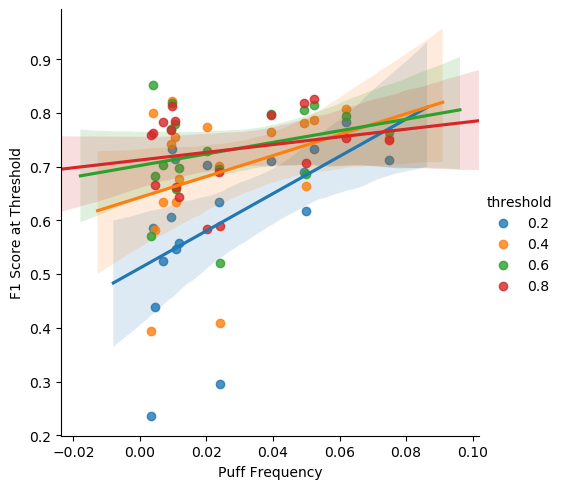

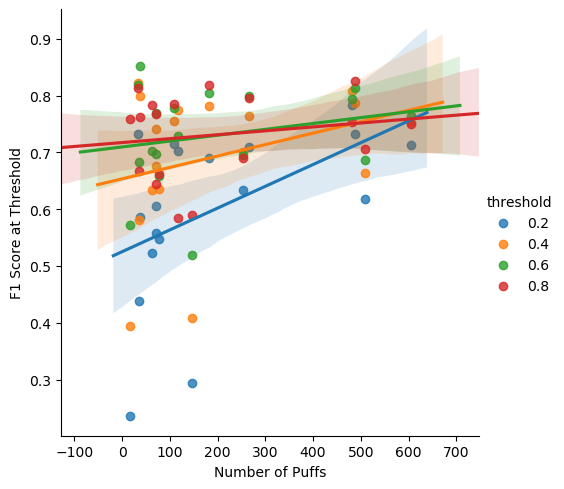

In [61]:
g = sns.lmplot(data=scores_for_thresh, x='puff_freq', y='f1_score', hue='threshold')
g.set(xlabel='Puff Frequency', ylabel='F1 Score at Threshold')
g1 = sns.lmplot(data=scores_for_thresh, x='num_puffs', y='f1_score', hue='threshold')
g1.set(xlabel='Number of Puffs', ylabel='F1 Score at Threshold')

There's some relationship between puff frequency and performance, albeit weak. Let's see if black box label shift estimation works to rectify some of that. Again, here we'll use the round robin classifier to test on held out cells, then use the probability distributions to compute the estimated base rate of cells.

As noted above, there's a lot of variability of the puff rate across the cells in the dataset:

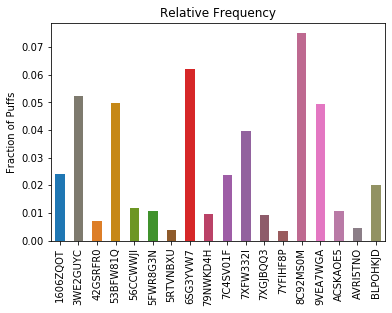

In [54]:
cell_res = pd.DataFrame({'cell': np.unique(labeled_sample['cell'])})

for cell in cell_res['cell']:
    cell_puffs = labeled_sample.loc[labeled_sample['cell'] == cell, 'puff']
    cell_res.loc[cell_res['cell'] == cell , 'n'] = len(cell_puffs)
    cell_res.loc[cell_res['cell'] == cell , 'true_count'] = np.sum(cell_puffs)
    cell_res.loc[cell_res['cell'] == cell , 'true_frac'] = np.mean(cell_puffs)

ax = cell_res.plot.bar(x = 'cell', y = 'true_frac', color=cell_pal, legend = False)
ax.set_xlabel('')
ax.set_ylabel('Fraction of Puffs')
ax.set_title('Relative Frequency')
plt.show()

We can test against several methods for estimating the baserate:

- Estimate rate as the average puff probability (the mean of the returned probabilities)
- Estimate rate as fraction of the events with a probability of a given cutoff
- Estimate rate using the black box label shift estimation from Lipton et al. 2018

Here we test each of these, and display the results as ratio of estimate to actual puff rate for each cell:

In [64]:
# BBSE from Lipton et al 2018
def base_rate_correction(train_y, train_f, test_f, thresh=0.5):
    _, train_props = np.unique(train_y, return_counts=True)
    train_props = train_props*1.0/len(train_y)
    train_conf = pd.crosstab(index=train_f>thresh, columns=train_y)
    train_conf = train_conf*1.0/train_conf.values.sum()
    _, test_pred_props = np.unique(test_f>thresh, return_counts=True)
    test_pred_props = test_pred_props*1.0/len(test_f)
    w = np.matmul(np.linalg.solve(train_conf, np.identity(2)), test_pred_props)
    muy = train_props*w
    return muy[1]

In [65]:
for held_cell, classifier in rr_classifiers.items():
    test_puff_probs = labeled_sample.loc[labeled_sample['cell']==held_cell, 'proba'].values
    train_puff_probs = classifier.oob_decision_function_[:,1]
    train_puff_labels = labeled_sample.loc[labeled_sample['cell']!=held_cell, 'puff'].values

    #Correct probabilities using cell matching
    cell_res.loc[cell_res['cell'] == held_cell ,'est_frac_raw_mean'] = np.mean(test_puff_probs)
    cell_res.loc[cell_res['cell'] == held_cell ,'est_frac_raw_thresh'] = np.mean(test_puff_probs > 0.5)
    cell_res.loc[cell_res['cell'] == held_cell, 'est_frac_corr'] = base_rate_correction(train_puff_labels,
                                                                                        train_puff_probs,
                                                                                        test_puff_probs, thresh=0.5)

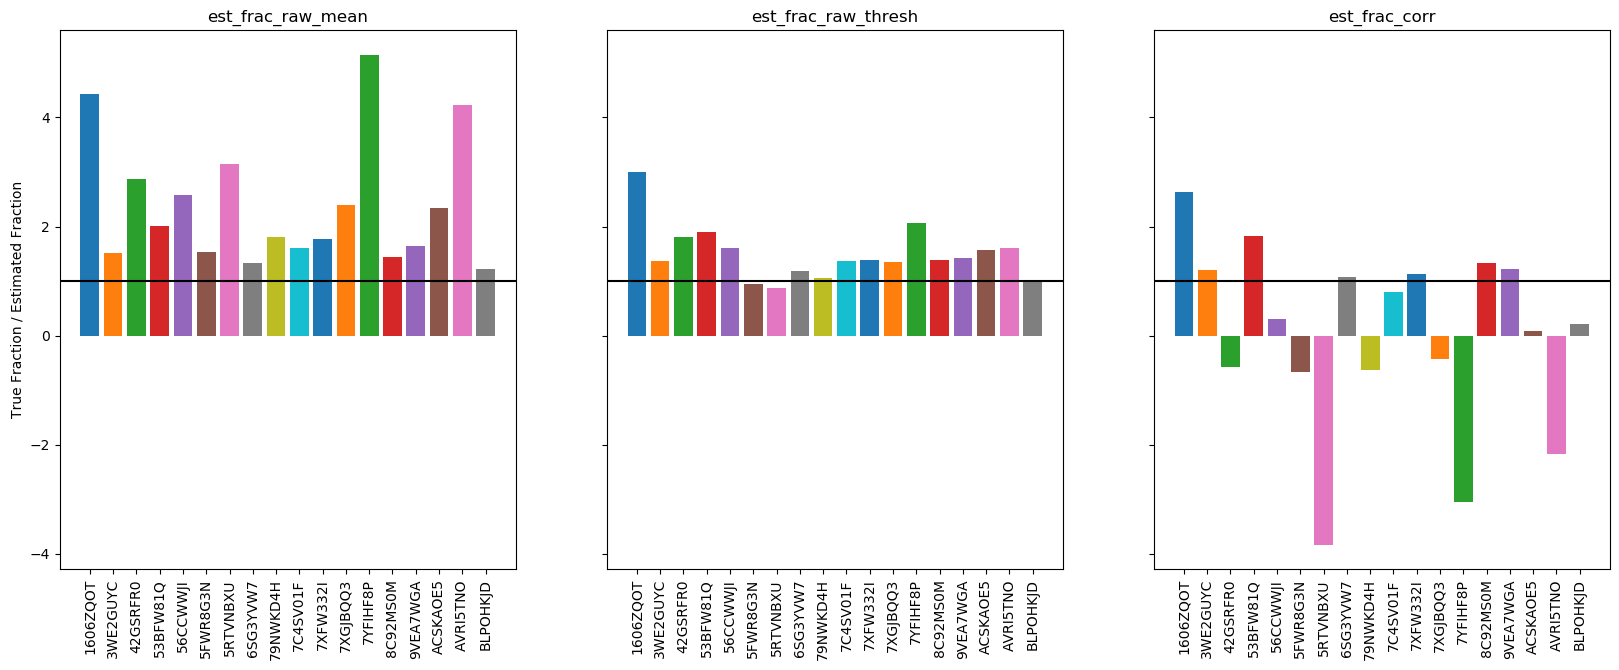

In [66]:
fig, axs = plt.subplots(1, 3, sharey = True, figsize=(20,7))
axs[0].set_ylabel('True Fraction / Estimated Fraction')

pred_diff = {}
for ax, est in enumerate(['est_frac_raw_mean', 'est_frac_raw_thresh', 'est_frac_corr']):
    pred_diff[est] = cell_res[est] / cell_res['true_frac']
    for counter, cell in enumerate(cell_res['cell']):
        axs[ax].bar(cell, pred_diff[est][counter])
    axs[ax].set_xticklabels(cell_res['cell'], rotation='vertical')
    axs[ax].axhline(y=1, color = 'black')
    axs[ax].set_title(est)

The BBSE estimation seems to be the worst estimator, which is surprising given our past results. I hypothesized that because of the variety of cells in the dataset, that estimation was off because the overall distribution of puffs to nonpuffs in the dataset did not resemble any of the cells themselves. To test this, I calculated a simple distance between each cell's probability distribution with all other cells, and then against all cells combined:

In [62]:
from scipy.stats import wasserstein_distance as wd
dists = {}
for cell in np.unique(labeled_sample['cell']):
    other_cells = [c for c in np.unique(labeled_sample['cell']) if c != cell]
    dist = {c: wd(labeled_sample[labeled_sample['cell'] == cell]['proba'].values,
               labeled_sample[labeled_sample['cell'] == c]['proba'].values) for c in other_cells}
    dist['All'] = wd(labeled_sample[labeled_sample['cell'] == cell]['proba'].values,
                     labeled_sample[labeled_sample['cell'] != cell]['proba'].values)
    dists[cell] = dist

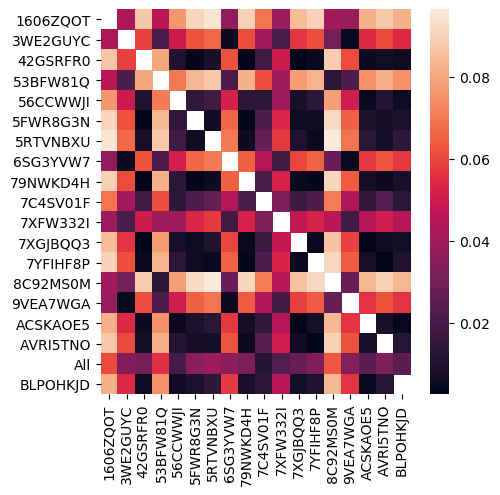

In [63]:
plt.figure(figsize=(5,5))
g = sns.heatmap(pd.DataFrame(dists).sort_index())
g.set_ylim(len(pd.DataFrame(dists)), 0)
plt.show()

I went on to see that if BBSE is estimated off of similar looking cells (based on the above distance calculation), can we get better estimates?

In [67]:
def get_close_cells(train_puff_probs, test_puff_probs, cell_memberships, k=3):
    cell_list = np.unique(cell_memberships)
    dists = [wd(test_puff_probs,
                train_puff_probs[cell_memberships == c]) for c in cell_list]
    return cell_list[np.argsort(dists)][0:k]

def correct_on_close_cells(train_puff_labels, train_puff_probs, test_puff_probs, cell_memberships, k=3):
    close_cells = get_close_cells(train_puff_probs, test_puff_probs, cell_memberships, k=k)
    close_train_probs = train_puff_probs[np.isin(cell_memberships, close_cells)]
    close_train_labels = train_puff_labels[np.isin(cell_memberships, close_cells)]
    return base_rate_correction(close_train_labels, close_train_probs, test_puff_probs)

In [68]:
for held_cell, classifier in rr_classifiers.items():
    test_puff_probs = labeled_sample.loc[labeled_sample['cell']==held_cell, 'proba'].values
    train_puff_probs = classifier.oob_decision_function_[:,1]
    train_puff_labels = labeled_sample.loc[labeled_sample['cell']!=held_cell, 'puff'].values
    cell_memberships = labeled_sample.loc[labeled_sample['cell']!=held_cell, 'cell'].values
    cell_res.loc[cell_res['cell'] == held_cell ,'est_frac_raw_mean'] = np.mean(test_puff_probs)
    cell_res.loc[cell_res['cell'] == held_cell ,'est_frac_raw_thresh'] = np.mean(test_puff_probs > 0.5)
    cell_res.loc[cell_res['cell'] == held_cell, 'est_frac_corr'] = base_rate_correction(train_puff_labels,
                                                                                        train_puff_probs,
                                                                                        test_puff_probs, thresh=0.5)
    cell_res.loc[cell_res['cell'] == held_cell, 'est_frac_corr_matched'] = correct_on_close_cells(train_puff_labels,
                                                                                                  train_puff_probs,
                                                                                                  test_puff_probs,
                                                                                                  cell_memberships,
                                                                                                  k=2)

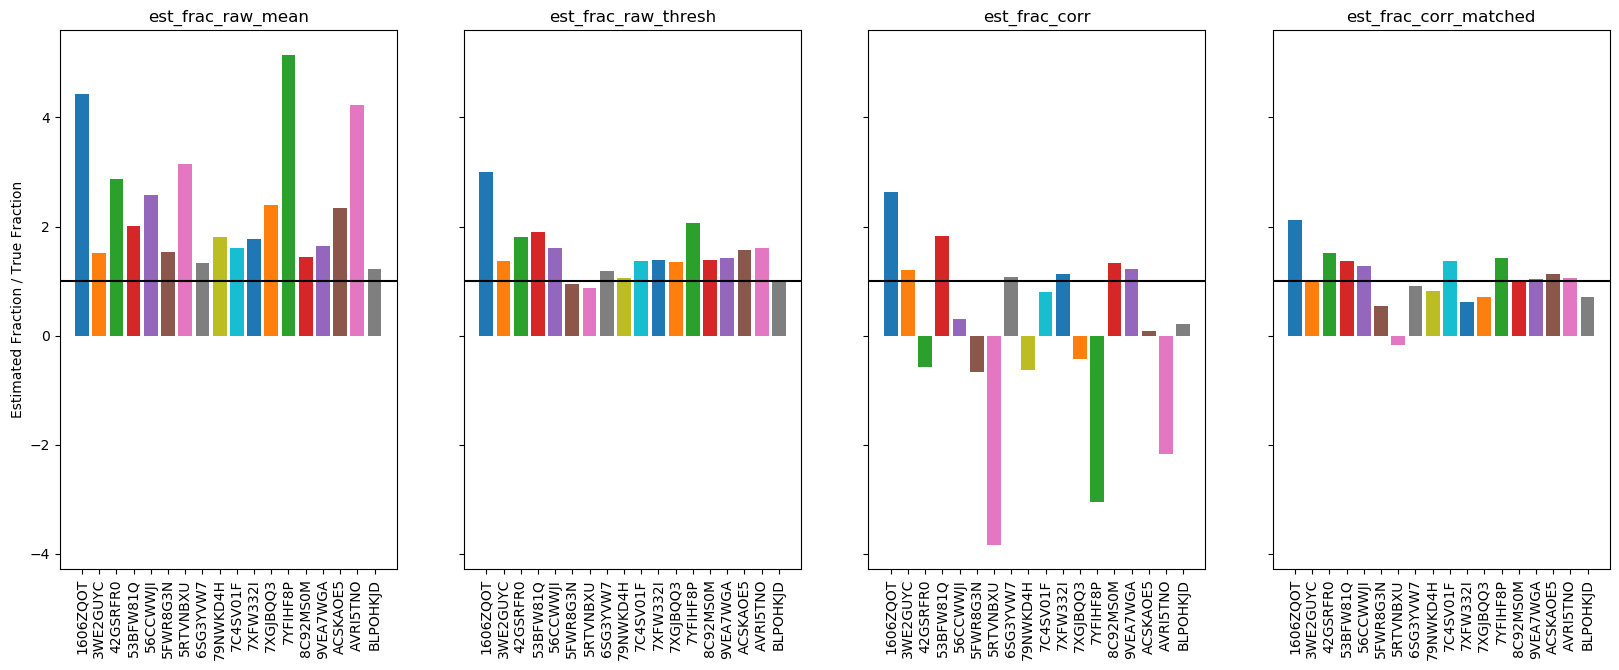

In [69]:
fig, axs = plt.subplots(1, 4, sharey = True, figsize=(20,7))
axs[0].set_ylabel('Estimated Fraction / True Fraction')

pred_diff = {}
for ax, est in enumerate(['est_frac_raw_mean', 'est_frac_raw_thresh', 'est_frac_corr', 'est_frac_corr_matched']):
    pred_diff[est] = cell_res[est] / cell_res['true_frac']
    for counter, cell in enumerate(cell_res['cell']):
        axs[ax].bar(cell, pred_diff[est][counter])
    axs[ax].set_xticklabels(cell_res['cell'], rotation='vertical')
    axs[ax].axhline(y=1, color = 'black')
    axs[ax].set_title(est)